In [1]:
import pymc3 as pm
import theano
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import exoplanet as xo
from exoplanet.distributions import Angle

import pymc3_ext as pmx
#from celerite2.theano import terms, GaussianProcess

import astropy.units as u
from astropy import constants
from astropy.time import Time
#from matplotlib.patches import Ellipse


# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
rad_2_deg = 180 / np.pi
yr = 365.25

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from sigfig import round

def get_median_sigma(pos):
    """
    Helper function to estimate median and sigma from posterior distribution
    Args:
        pos: array from posterior distribution
    Returns:
        (median,sigma): best fit value and 1 sigma uncertainty
    """
    temp = np.percentile(pos,[16,50,84])
    lower = temp[1]-temp[0]
    upper = temp[2]-temp[1]
    sigma = np.max([lower,upper])
    
    return (temp[1], sigma)

Median MJD TO95 48635.456400000025
Median JD FEROS 54310.966950000264
Median JD FEROS2 57062.27270000009
Median MJD CTIO 59411.9949
Median MJD ELODIE 50841.6274195


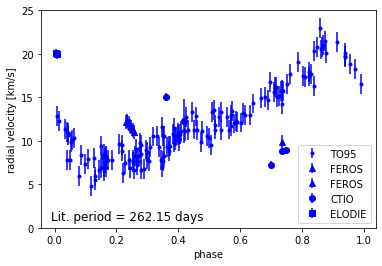

In [5]:
# Read RV data
RV_Aa = pd.read_csv('RV_Aa.csv')

t = RV_Aa['HJD'].to_numpy()
rva = RV_Aa['Aa'].to_numpy()
rva_err = RV_Aa['Aa_err'].to_numpy()

print("Median MJD TO95", np.median(t)- 2400000.5)

# Read FEROS RV data
RV_Aa = pd.read_csv('RV_Aa_FEROS.csv')

t_FEROS = RV_Aa['MJD'].to_numpy()

t_FEROS = t_FEROS  + 2400000.0 # MJD to JD
print("Median JD FEROS", (np.median(t_FEROS)- 2400000.5))
rva_FEROS = RV_Aa['Aa'].to_numpy()
rva_err_FEROS = RV_Aa['Aa_err'].to_numpy()

# Read FEROS RV data
RV_Aa = pd.read_csv('RV_Aa_FEROS2.csv')

t_FEROS2 = RV_Aa['MJD'].to_numpy()
t_FEROS2 = t_FEROS2  + 2400000.0 # MJD to JD
print("Median JD FEROS2", (np.median(t_FEROS2)- 2400000.5))
rva_FEROS2 = RV_Aa['Aa'].to_numpy()
rva_err_FEROS2 = RV_Aa['Aa_err'].to_numpy()


# Read CHIRON RV data
RV_Aa = pd.read_csv('RV_Aa_CTIO.csv')

t_CTIO = RV_Aa['MJD'].to_numpy()
print("Median MJD CTIO", np.median(t_CTIO))
t_CTIO = t_CTIO  + 2400000.5 # MJD to JD
rva_CTIO = RV_Aa['Aa'].to_numpy()
rva_err_CTIO = RV_Aa['Aa_err'].to_numpy()

# Read ELODIE RV data
RV_Aa = pd.read_csv('RV_Aa_ELODIE.csv')

t_ELODIE = RV_Aa['MJD'].to_numpy()
print("Median MJD ELODIE", np.median(t_ELODIE))
t_ELODIE = t_ELODIE  + 2400000.5 # MJD to JD
rva_ELODIE = RV_Aa['Aa'].to_numpy()
rva_err_ELODIE = RV_Aa['Aa_err'].to_numpy()



# Plot the observations "folded" on the published period:
# Torres et al. 1995
lit_period = 262.15

# Primary
plt.errorbar(
    (t % lit_period) / lit_period, rva, yerr=rva_err, fmt=".b", capsize=0, label="TO95"
)

plt.errorbar(
    (t_FEROS % lit_period) / lit_period, rva_FEROS, yerr=rva_err_FEROS, fmt="^b", capsize=0, label="FEROS"
)

plt.errorbar(
    (t_FEROS2 % lit_period) / lit_period, rva_FEROS2, yerr=rva_err_FEROS2, fmt="^b", capsize=0, label="FEROS"
)

plt.errorbar(
    (t_CTIO % lit_period) / lit_period, rva_CTIO, yerr=rva_err_CTIO, fmt="ob", capsize=0, label="CTIO"
)

plt.errorbar(
    (t_ELODIE % lit_period) / lit_period, rva_ELODIE, yerr=rva_err_ELODIE, fmt="sb", capsize=0, label="ELODIE"
)

#plt.xlim(0, 1)
plt.ylim(0, 25)
plt.annotate(
    "Lit. period = {0:.2f} days".format(lit_period),
    xy=(0.5, 0),
    xycoords="axes fraction",
    xytext=(-5, 5),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize=12,
)

plt.legend()

plt.ylabel("radial velocity [km/s]")
_ = plt.xlabel("phase")

In [6]:
#Define the model to fit SB1

with pm.Model() as model:

    # Parameters initial values from Torres et al. 1995
    logK1 = pm.Uniform(
        "logK1",
        lower=np.log(4),
        upper=np.log(20),
        testval=np.log(6.81),
    )
    
    
    logP = pm.Uniform(
        "logP", lower=np.log(200), upper=np.log(300), testval=np.log(264.51)
    )
    
    P = pm.Deterministic("P", tt.exp(logP))
    #Primary
    K1 = pm.Deterministic("K1", tt.exp(logK1))
   
    phase = pmx.UnitUniform("phase")
    # For these orbits, it can also be better to fit for a phase angle
    # (relative to a reference time) instead of the time of periasteron
    # passage directly
    tp = pm.Deterministic("tp", 0.5 * (t.min() + t.max()) + phase * P)

    # Parameterize the eccentricity using:
    #  h = sqrt(e) * cos(w)
    #  k = sqrt(e) * sin(w)
    # testval from Torres et al. 1995 (e ~ 0.484 and omega ~ 64.4 deg)
    hk = xo.UnitDisk("hk", testval=np.array([-0.29, 0.83]))
    #hk = xo.UnitDisk("hk", testval=np.array([0.29, -0.83]))
    ecc = pm.Deterministic("e", hk[0] ** 2 + hk[1] ** 2)
    omega = pm.Deterministic("w", tt.arctan2(hk[1], hk[0]))
    
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t_periastron=tp, ecc=ecc, omega=omega
    )
    

    gamma = pm.Uniform("gamma",lower=0,upper=20,testval=12)
    gamma_FEROS = pm.Uniform("gamma_FEROS",lower=0,upper=20,testval=14)
    gamma_FEROS2 = pm.Uniform("gamma_FEROS2",lower=0,upper=20,testval=14)
    gamma_CTIO = pm.Uniform("gamma_CTIO", lower=0,upper=30,testval=10)
    gamma_ELODIE = pm.Uniform("gamma_ELODIE", lower=0,upper=30,testval=10)
    
    logjit_TO95 = pm.Uniform("logjitterTO95", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_FEROS = pm.Uniform("logjitterFEROS", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_FEROS2 = pm.Uniform("logjitterFEROS2", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_CTIO = pm.Uniform("logjitterCTIO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    logjit_ELODIE = pm.Uniform("logjitterELODIE", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
    jit_TO95 = pm.Deterministic("jitTO95", tt.exp(logjit_TO95))
    jit_FEROS = pm.Deterministic("jitFEROS", tt.exp(logjit_FEROS))
    jit_FEROS2 = pm.Deterministic("jitFEROS2", tt.exp(logjit_FEROS2))
    jit_CTIO = pm.Deterministic("jitCTIO", tt.exp(logjit_CTIO))
    jit_ELODIE = pm.Deterministic("jitELODIE", tt.exp(logjit_ELODIE))
    
    # get the total errors
    def get_err(rv_err, logjitter):
        return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))

    # Set up the radial velocity model
    def model_rv1(jd, offset):
        return offset + orbit.get_radial_velocity(jd,K=K1)
   
    #Primary
    rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t, gamma))
    rvmodel_a_FEROS = pm.Deterministic("rvmodel_a_FEROS", model_rv1(t_FEROS, gamma_FEROS))
    rvmodel_a_FEROS2 = pm.Deterministic("rvmodel_a_FEROS2", model_rv1(t_FEROS2, gamma_FEROS2))
    rvmodel_a_CTIO = pm.Deterministic("rvmodel_a_CTIO", model_rv1(t_CTIO, gamma_CTIO))
    rvmodel_a_ELODIE = pm.Deterministic("rvmodel_a_ELODIE", model_rv1(t_ELODIE, gamma_ELODIE))
        

    # Condition on the observations
    pm.Normal("obs_a", mu=rvmodel_a, sd=get_err(rva_err, logjit_TO95), observed=rva)
    pm.Normal("obs_a_FEROS", mu=rvmodel_a_FEROS, sd=get_err(rva_err_FEROS, logjit_FEROS), observed=rva_FEROS)
    pm.Normal("obs_a_FEROS2", mu=rvmodel_a_FEROS2, sd=get_err(rva_err_FEROS2, logjit_FEROS2), observed=rva_FEROS2)
    pm.Normal("obs_a_CTIO", mu=rvmodel_a_CTIO, sd=get_err(rva_err_CTIO, logjit_CTIO), observed=rva_CTIO)
    pm.Normal("obs_a_ELODIE", mu=rvmodel_a_ELODIE, sd=get_err(rva_err_ELODIE, logjit_ELODIE), observed=rva_ELODIE)

    # Optimize the logp
    map_soln = model.test_point
    #map_soln = pmx.optimize(map_soln, [gamma, gamma_2])
    #map_soln = pmx.optimize(map_soln, [gamma, phase, gamma_2])
    map_soln = pmx.optimize(map_soln, [gamma, gamma_FEROS, gamma_FEROS2, gamma_CTIO, gamma_ELODIE, phase, logK1])
    map_soln = pmx.optimize(map_soln)

optimizing logp for variables: [logK1, phase, gamma_ELODIE, gamma_CTIO, gamma_FEROS2, gamma_FEROS, gamma]


message: Optimization terminated successfully.
logp: -1608.6373514900824 -> -441.65018343602964
optimizing logp for variables: [logjitterELODIE, logjitterCTIO, logjitterFEROS2, logjitterFEROS, logjitterTO95, gamma_ELODIE, gamma_CTIO, gamma_FEROS2, gamma_FEROS, gamma, hk, phase, logP, logK1]


message: Desired error not necessarily achieved due to precision loss.
logp: -441.65018343602964 -> -274.09999162456376


[0.51517381 0.51517381]
[0.80748705 0.80748705 0.80748705 0.80748705 0.80748705 0.80748705
 0.80748705 0.80748705]
[0.82120295]
[0.50708553 2.50142674 0.50708553 0.21710765 0.21710765]
1.1934231719686248


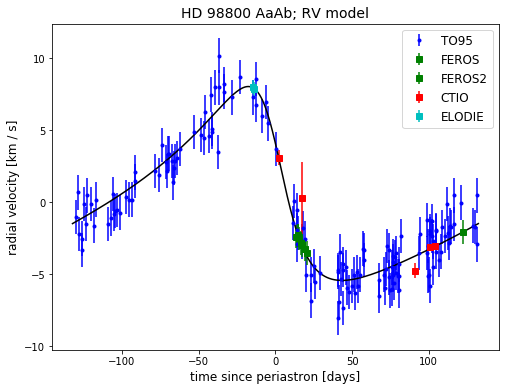

In [7]:
period = map_soln["P"]
tp = map_soln["tp"]
gamma = map_soln["gamma"]
gamma_FEROS = map_soln["gamma_FEROS"]
gamma_FEROS2 = map_soln["gamma_FEROS2"]
gamma_CTIO = map_soln["gamma_CTIO"]
gamma_ELODIE = map_soln["gamma_ELODIE"]

fig, axes = plt.subplots(figsize=(8, 6))

ELO_errA = np.sqrt(rva_err_ELODIE**2 + np.exp(2 * np.median(map_soln["logjitterELODIE"])))

TO95_errA = np.sqrt(rva_err**2 + np.exp(2 * np.median(map_soln["logjitterTO95"])))

CTIO_errA = np.sqrt(rva_err_CTIO**2 + np.exp(2 * np.median(map_soln["logjitterCTIO"])))

FEROS_errA = np.sqrt(rva_err_FEROS**2 + np.exp(2 * np.median(map_soln["logjitterFEROS"])))

FEROS2_errA = np.sqrt(rva_err_FEROS2**2 + np.exp(2 * np.median(map_soln["logjitterFEROS2"])))

print(ELO_errA)

print(FEROS_errA)

print(FEROS2_errA)

print(CTIO_errA)

print(np.median(TO95_errA))

    
#xx = [-0.5 * period, 0.5 * period]
#yy = [gamma, gamma]

#plt.plot(xx,yy,'--',c='k',alpha = 0.8)

folded = ((t - tp + 0.5 * period) % period) - 0.5 * period
folded_F = ((t_FEROS - tp + 0.5 * period) % period) - 0.5 * period
folded_F2 = ((t_FEROS2 - tp + 0.5 * period) % period) - 0.5 * period
folded_C = ((t_CTIO - tp + 0.5 * period) % period) - 0.5 * period
folded_E = ((t_ELODIE - tp + 0.5 * period) % period) - 0.5 * period

plt.errorbar(folded, rva-gamma, yerr=TO95_errA, fmt=".b",label="TO95")
plt.errorbar(folded_F, rva_FEROS-gamma_FEROS, yerr=FEROS_errA, fmt="sg",label="FEROS")
plt.errorbar(folded_F2, rva_FEROS2-gamma_FEROS2, yerr=FEROS2_errA, fmt="sg",label="FEROS2")
plt.errorbar(folded_C, rva_CTIO-gamma_CTIO, yerr=CTIO_errA, fmt="sr",label="CTIO")
plt.errorbar(folded_E, rva_ELODIE-gamma_ELODIE, yerr=ELO_errA, fmt="sc",label="ELODIE")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)

with model:
    y1_mod = xo.eval_in_model(model_rv1(x_phase + tp, gamma), map_soln)

#print(period)
plt.plot(x_phase, y1_mod-gamma, "k")

plt.legend(fontsize=12)
plt.ylabel("radial velocity [km / s]", fontsize=12)
plt.xlabel("time since periastron [days]", fontsize=12)
_ = plt.title("HD 98800 AaAb; RV model", fontsize=14)

In [8]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=4500, draws=4000, start=map_soln, chains=4, cores=4, target_accept=0.9
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterELODIE, logjitterCTIO, logjitterFEROS2, logjitterFEROS, logjitterTO95, gamma_ELODIE, gamma_CTIO, gamma_FEROS2, gamma_FEROS, gamma, hk, phase, logP, logK1]


Sampling 4 chains for 4_500 tune and 4_000 draw iterations (18_000 + 16_000 draws total) took 224 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


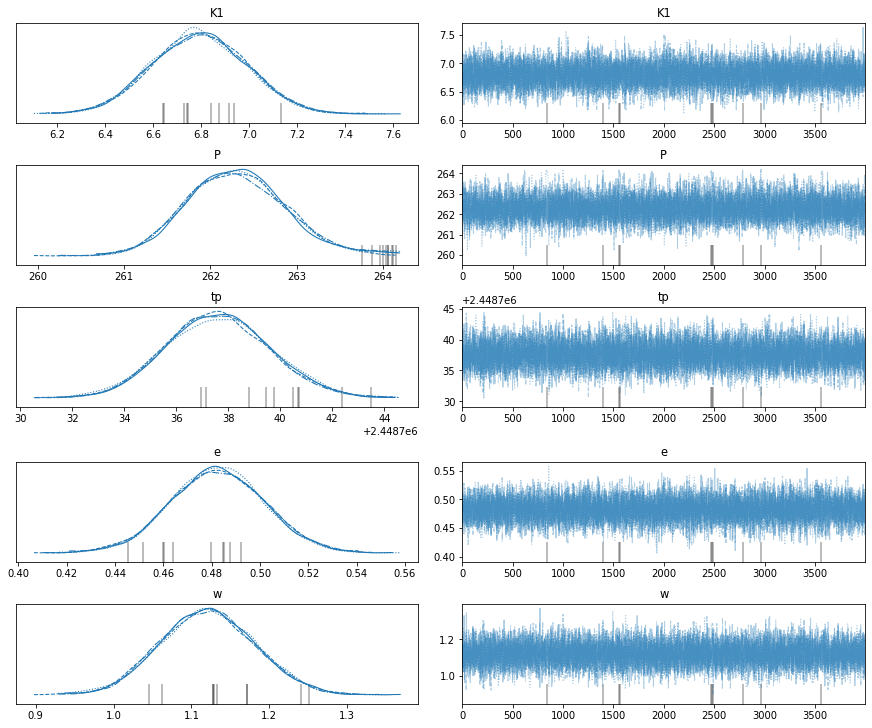

In [8]:
with model:
    _ = pm.traceplot(trace, var_names=["K1", "P", "tp", "e", "w"])

In [9]:
with model:
    summary = pm.summary(
        trace,
        var_names=["K1", "P", "e", "w", "gamma", "tp"],
        round_to = 3
    )
summary

mean     sd       hdi_3%      hdi_97%  mcse_mean  mcse_sd  \
K1           6.780  0.196        6.423        7.155      0.002    0.001   
P          262.473  0.615      261.316      263.652      0.017    0.012   
e            0.482  0.019        0.446        0.519      0.000    0.000   
w            1.124  0.061        1.010        1.236      0.001    0.000   
gamma       12.759  0.099       12.573       12.947      0.001    0.001   
tp     2448737.884  1.993  2448734.339  2448741.750      0.027    0.019   

        ess_mean     ess_sd   ess_bulk   ess_tail  r_hat  
K1      9938.026   9938.026   9814.860   9521.663  1.001  
P       1258.667   1252.547   1689.510    611.189  1.003  
e      11991.236  11950.569  11989.294  10256.813  1.000  
w      12201.572  12201.572  12198.723  10668.874  1.000  
gamma  11678.211  11678.211  11753.891  10103.152  1.000  
tp      5649.413   5645.440   5653.396   3697.860  1.001

Period (days): 262.4$\pm$0.6
Tp (MJD): 48737$\pm$2
omega (deg): 64$\pm$3
e: 0.48$\pm$0.02
K1 (km/s): 6.8$\pm$0.2
gamma TO95 (km/s): 12.8$\pm$0.1
gamma FEROS (km/s): 16.6$\pm$0.6
gamma FEROS 2 (km/s): 7$\pm$2
gamma CTIO (km/s): 10$\pm$3
gamma ELODIE (km/s): 18$\pm$3


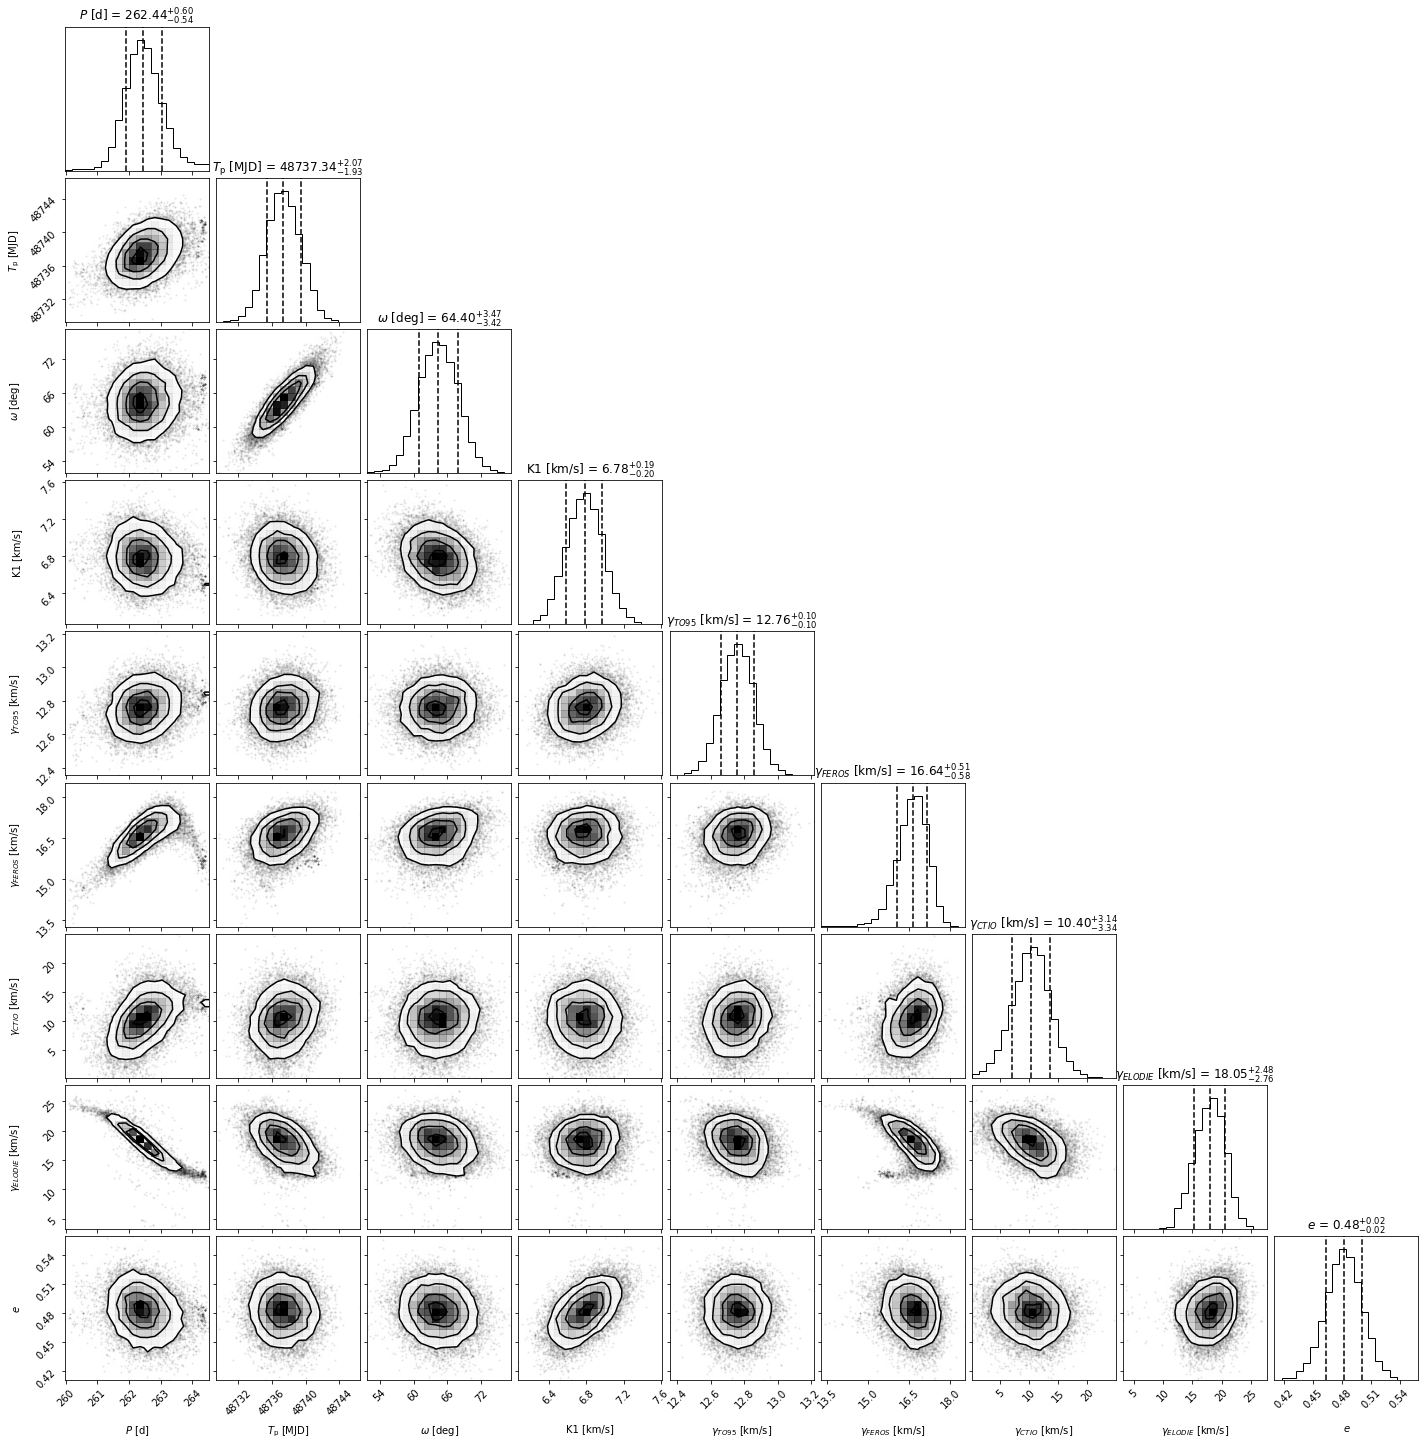

In [10]:

samples = pm.trace_to_dataframe(trace, varnames=["e"])
samples["$P$ [d]"] = trace["P"]
samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
samples["$\omega$ [deg]"] = (trace["w"] * rad_2_deg) % 360
samples["K1 [km/s]"] = (trace["K1"]) 
samples["$\gamma_{TO95}$ [km/s]"] = (trace["gamma"])
samples["$\gamma_{FEROS}$ [km/s]"] = (trace["gamma_FEROS"])
samples["$\gamma_{CTIO}$ [km/s]"] = (trace["gamma_CTIO"])
samples["$\gamma_{ELODIE}$ [km/s]"] = (trace["gamma_ELODIE"])
samples["$e$"] = samples["e"]

period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["w"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["e"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma_FEROS"])
print("gamma FEROS (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma_FEROS2"])
print("gamma FEROS 2 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma_CTIO"])
print("gamma CTIO (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma_ELODIE"])
print("gamma ELODIE (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))


del samples["e"]
_ = corner.corner(samples,quantiles=[0.16,0.50,0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

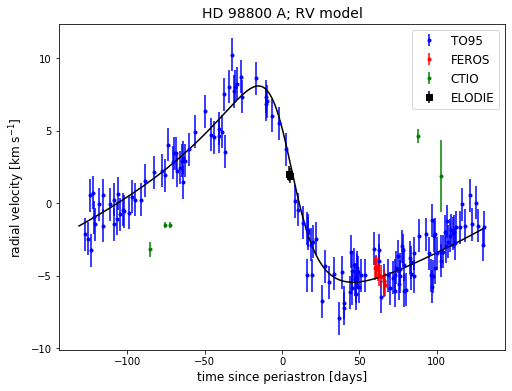

In [11]:
period_RV =  np.percentile(trace["P"], [16,50,84], axis=0)
tp_RV = np.percentile(trace["tp"], [16,50,84], axis=0)
gamma_RV = np.percentile(trace["gamma"], [16,50,84], axis=0)
gamma_FEROS = np.percentile(trace["gamma_FEROS"], [16,50,84], axis=0)
gamma_CTIO = np.percentile(trace["gamma_CTIO"], [16,50,84], axis=0)
gamma_ELODIE = np.percentile(trace["gamma_ELODIE"], [16,50,84], axis=0)
K1_RV = np.percentile(trace["K1"], [16,50,84], axis=0)
omega_RV = np.percentile(trace["w"], [16,50,84], axis=0)
ecc_RV = np.percentile(trace["e"], [16,50,84], axis=0)

fig, axes = plt.subplots(figsize=(8, 6))

    
#xx = [-0.5 * period_RV[1], 0.5 * period_RV[1]]
#yy = [gamma_RV[1], gamma_RV[1]]

#plt.plot(xx,yy,'--',c='k',alpha = 0.9)

folded = ((t - tp_RV[1] + 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]
folded_F = ((t_FEROS - tp_RV[1] + 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]
folded_C = ((t_CTIO - tp_RV[1] + 0.5 * period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]
folded_E = ((t_ELODIE - tp_RV[1] + 0.5 *period_RV[1]) % period_RV[1]) - 0.5 * period_RV[1]

plt.errorbar(folded, rva - gamma_RV[1], yerr=rva_err, fmt=".b",label="TO95")
plt.errorbar(folded_F, rva_FEROS - gamma_FEROS[1], yerr=rva_err_FEROS, fmt=".r",label="FEROS")
plt.errorbar(folded_C, rva_CTIO - gamma_CTIO[1], yerr=rva_err_CTIO, fmt=".g",label="CTIO")
plt.errorbar(folded_E, rva_ELODIE - gamma_ELODIE[1], yerr=rva_err_ELODIE, fmt="sk",label="ELODIE")

x_phase = np.linspace(-0.5 * period_RV[1], 0.5 * period_RV[1], 500)

with model:
    y1_mod = xo.eval_in_model(model_rv1(x_phase + tp_RV[1], gamma_RV[1]), map_soln)
    


plt.plot(x_phase, y1_mod-gamma_RV[1], "k")
#plt.plot(x_phase, y2_mod, "C1")



#plt.scatter(t, detrended)

plt.legend(fontsize=12)
#plt.xlim(-0.5 * period/period, 0.5 * period)
plt.ylabel("radial velocity [$\mathrm{km~s^{-1}}$]", fontsize=12)
plt.xlabel("time since periastron [days]", fontsize=12)
_ = plt.title("HD 98800 A; RV model", fontsize=14)

In [12]:
# Lets try now with a joint-fit (astrometry+RV)

# Read astrometry 
astrometry_elipse_A = pd.read_csv('HD98800A_astrometry.csv')


# The uncertainties in the astrometry from optical interferomtry should be represented with an elipse error
# i.e PA, sigma_maj, sigma_min (see Gallenne et al. 2015). 

t_astro = astrometry_elipse_A['MJD'].to_numpy()
astro_jds = t_astro + 2400000.5 # MJD to JD


x = astrometry_elipse_A['x'].to_numpy()
y = astrometry_elipse_A['y'].to_numpy()

# Semi major axis (sigma_maj) as a astrometry x,y error (to be conservative).
x_err = astrometry_elipse_A['sigma_maj'].to_numpy()
y_err = astrometry_elipse_A['sigma_maj'].to_numpy()

# error elipse
astro_sigma_maj = astrometry_elipse_A['sigma_maj'].to_numpy() #semi-major axis
astro_sigma_min = astrometry_elipse_A['sigma_min'].to_numpy() # semi-minor axis
astrometry_PA = astrometry_elipse_A['PA'].to_numpy() # position angle

# Quick test to visualize the error elipse
#th = np.linspace(0,2*np.pi,100)
#angle = astrometry_PA[1]*deg
#_x, _y = astro_sigma_maj[1]*np.cos(th), astro_sigma_min[1]*np.sin(th)
#_x, _y = _x*np.cos(angle)+_y*np.sin(angle), -_y*np.cos(angle)+_x*np.sin(angle)
#_x += x[1]
#_y += y[1]

#fig, ax = plt.subplots(nrows=1, figsize=(6, 6))
#plt.plot(_x, _y, linestyle='-', color='r', linewidth=2)
#plt.show()

In [13]:
# We held the orbital period, eccentricity and longitude of periastron fixed to the spectroscopic
# solution and fit only for the orbital inclination (i), the angular semimajor axis (a), and the 
# longitude of the ascending node (Ω).  

yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=parallax[0]-5*parallax[1], upper=parallax[0]+5*parallax[1])(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.005, 0.1, testval=0.02)
        a = pm.Deterministic("a", a_ang / plx) ## a(AU)
        
        # From our RV fit 
        logP = pm.Uniform(
            "logP", lower=np.log(260), upper=np.log(270), testval=np.log(period_RV[1])
        )
        P = pm.Deterministic("P", tt.exp(logP))
        
        K1 = K1_RV[1]
        gamma = gamma_RV[1]
        gamma_F = gamma_FEROS[1]
        ecc = ecc_RV[1]
        
        tp = pm.Normal("tp", mu = tp_RV[1], sd = tp_RV[0], testval=tp_RV[1])
        
        omega = omega_RV[1]

        
        # New orbital parameters to be fitted with astromety
        Omega0 = 190 * deg
        Omega = pm.Uniform("Omega", lower=0.0, upper=2*np.pi, testval=Omega0)
        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval= np.cos(160 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a= a * au_to_R_sun,
            t_periastron= tp,
            period= P,
            incl= incl,
            ecc= ecc,
            omega= omega,
            Omega= Omega,
        )
        
        # Set up the radial velocity model
        def model_rv1(jd, offset):
            return offset + orbit.get_radial_velocity(jd,K=K1)
        
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t, gamma))
        rvmodel_a_FEROS = pm.Deterministic("rvmodel_a_FEROS", model_rv1(t_FEROS, gamma_F))
        
        # Condition on the observations
        pm.Normal("obs_a", mu=rvmodel_a, sd=rva_err, observed=rva)
        pm.Normal("obs_a_FEROS", mu=rvmodel_a_FEROS, sd=rva_err_FEROS, observed=rva_FEROS)
        

        # Compute the model in x,y
        y_model, x_model, z_model = orbit.get_relative_position(astro_jds, plx)
        pm.Deterministic("x_model", x_model)
        pm.Deterministic("y_model", y_model)
        
        #elipse error model
        # semi-major axis error
        Maj_err = (x_model - x/1000)*tt.cos(astrometry_PA*deg)+(y_model- y/1000)*tt.sin(astrometry_PA*deg)
        # semi-minor axis error
        Min_err = -(y_model-y/1000)*tt.cos(astrometry_PA*deg)+(x_model-x/1000)*tt.sin(astrometry_PA*deg)
        
        # define the likelihood function
        pm.Normal("sigmaMaj_obs", mu=Maj_err, sd=astro_sigma_maj/1000, observed=0.0)
        pm.Normal("sigmaMin_obs", mu=Min_err, sd=astro_sigma_min/1000, observed=0.0)
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        

        va_dense = orbit.get_radial_velocity(t,K1)
        
        va_save = pm.Deterministic("va_save",va_dense)
        
        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln = model.test_point
        map_soln = pmx.optimize(map_soln)


    return model, map_soln

model, map_soln = get_model() 

optimizing logp for variables: [cos_incl, Omega, tp, logP, a_ang]


message: Desired error not necessarily achieved due to precision loss.
logp: -25278695.22348894 -> -3410.5328863805807


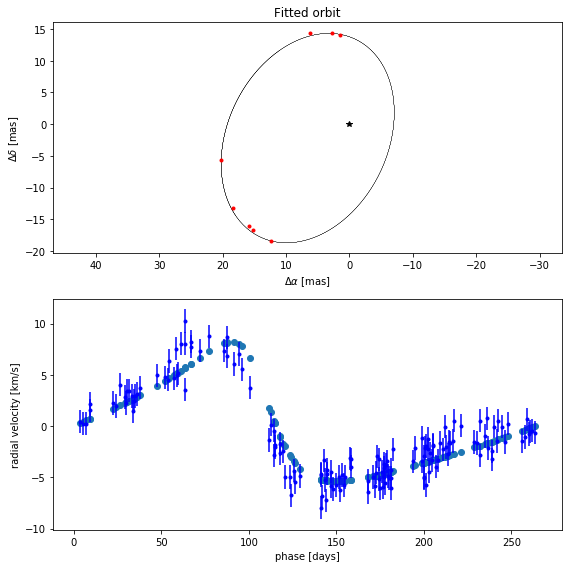

In [14]:
period = map_soln['P']

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax = axes[0]


ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=".r")
ax.plot(map_soln["x_save"]*1000, map_soln["y_save"]*1000, color = "k", lw=0.1)

ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit")

ax = axes[1]
ax.errorbar(t % period, rva - gamma_RV[1], yerr=rva_err, fmt=".b")
#ax.errorbar(t % period, rvb - map_soln["bkg"], yerr=rvb_err, fmt=".r")
ax.scatter(t % period, map_soln["va_save"], color = "C0", marker='o')
#ax.scatter(t % period, -map_soln["vb_save"], color = "C1", marker='o')

#q = np.percentile(trace["va_save"], [16, 84], axis=0)
#ax.fill_between(t_fine % period, q[0], q[1], color="C0", alpha=0.7, lw=0)

#q = np.percentile(trace["vb_save"], [16, 84], axis=0)
#ax.fill_between(t_fine % period, -q[0], -q[1], color="C1", alpha=0.7, lw=0)

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

#for i in np.random.randint(len(trace) * trace.nchains, size=25):
 #   axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)




#axes[0].set_ylim(-40, 50)
#axes[1].set_ylim(-40, 50)
#print(map_soln["M_t"])
#print(map_soln["M_tot"])
#print(map_soln["M_2"])
#print(map_soln["M_t"]-map_soln["M_2"])

plt.tight_layout()

In [15]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=3000, draws=2000, start=map_soln, chains=4, cores=4, target_accept=0.9
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cos_incl, Omega, tp, logP, a_ang]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 43 seconds.


In [20]:
# Then we can look at some summaries of the trace and the constraints on some of the key parameters:
with model:
    summary = pm.summary(
        trace,
        #var_names=["P", "gamma", "a_ang", "omega", "Omega", "incl", "ecc", "plx"],
        var_names=["P", "tp", "a_ang", "Omega", "incl"],
    )
summary

mean     sd       hdi_3%      hdi_97%  mcse_mean  mcse_sd  \
P          264.460  0.013      264.435      264.484      0.000    0.000   
tp     2448747.631  0.524  2448746.640  2448748.597      0.004    0.003   
a_ang        0.019  0.000        0.019        0.019      0.000    0.000   
Omega        2.847  0.001        2.845        2.849      0.000    0.000   
incl         2.320  0.001        2.318        2.322      0.000    0.000   

       ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
P       19126.0  19126.0   19116.0   13003.0    1.0  
tp      19175.0  19070.0   19079.0   12630.0    1.0  
a_ang   18414.0  18414.0   18428.0   12145.0    1.0  
Omega   18301.0  18300.0   18294.0   11841.0    1.0  
incl    18094.0  18093.0   18075.0   11400.0    1.0

Omega (deg): 163.44$\pm$0.05
i (deg): 133.17$\pm$0.06
a (mas): 19.098$\pm$0.006


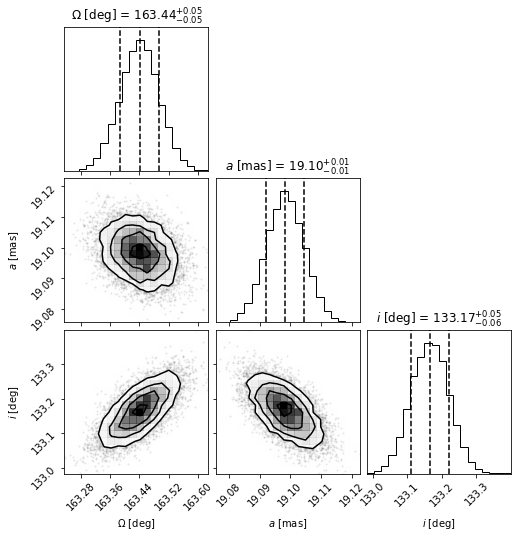

In [16]:
# Save posterior distribution
Omega_astro = np.percentile(trace["Omega"],[16,50,84],axis=0)
incl_astro = np.percentile(trace["incl"],[16,50,84],axis=0)
a_astro = np.percentile(trace["a_ang"],[16,50,84],axis=0)
tp_astro = np.percentile(trace["tp"],[16,50,84],axis=0)
P_astro = np.percentile(trace["P"],[16,50,84],axis=0)

samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$P$ [d]"] = trace["P"]
#samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
#samples["$\omega$ [deg]"] = (trace["omega"] * rad_2_deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
#samples["M2"] = (trace["M_2"]) 
#samples["M1"] = (trace["M_t"]-trace["M_2"])
#samples["$\gamma$ [km/s]"] = (trace["gamma"])
samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["$i$ [deg]"] = (trace["incl"] / deg) % 180
#samples["$\pi$ [mas]"] = trace["m_plx"]
#samples["$e$"] = samples["ecc"]

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), format='PDG', separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), format='PDG', separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
print("a (mas): "+round(str(aang), uncertainty=str(aang_s), format='PDG', separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 12})

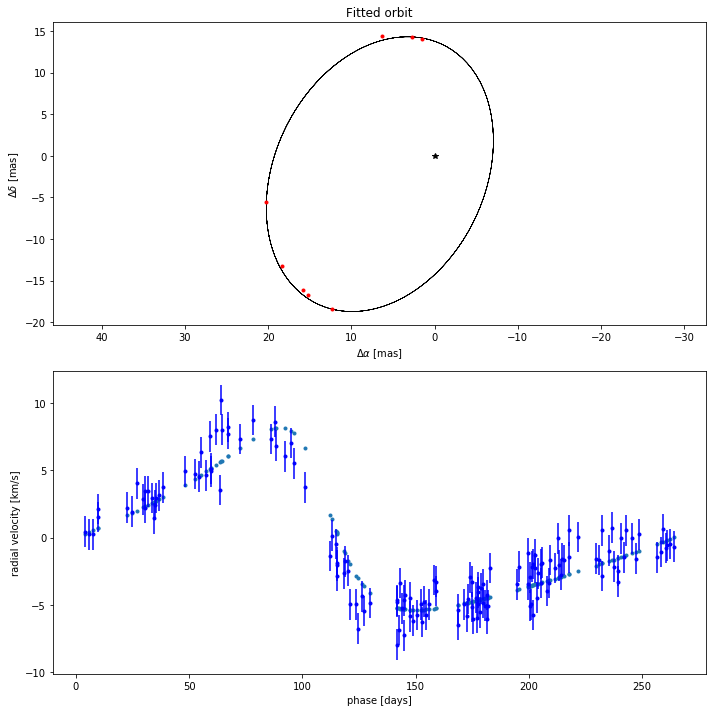

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

ax = axes[0]

period = np.median(trace["P"])
#tp = np.median(trace["tp"])
gamma = gamma_RV[1]

qx = np.percentile(trace["x_save"], [16, 50, 84], axis=0)
qy = np.percentile(trace["y_save"], [16, 50, 84], axis=0)


ax.set_ylabel(r"$\Delta \delta$ [mas]")
ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt=".r")
ax.plot(qx[1]*1000, qy[1]*1000, color = "k", lw=0.5)
#ax.plot(qx[0]*1000, qy[0]*1000, color = "k", lw=1.5, alpha = 0.2)
#ax.plot(qx[2]*1000, qy[2]*1000, color = "k", lw=1.5, alpha = 0.2)

ax.set_xlabel(r"$\Delta \alpha$ [mas]")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit")

ax = axes[1]
ax.errorbar(t % period, rva - gamma, yerr=rva_err, fmt=".b")
#ax.errorbar(t % period, rvb - map_soln["bkg"], yerr=rvb_err, fmt=".r")
ax.scatter(t%period, map_soln["va_save"], color = "C0", marker='.')
#ax.scatter(t%period, -map_soln["vb_save"], color = "C1", marker='.')

#q = np.percentile(trace["va_save"], [16, 84], axis=0)
#ax.fill_between(t % period, q[0], q[1], color="C0", alpha=0.7, lw=0)

#q = np.percentile(trace["vb_save"], [16, 84], axis=0)
#ax.fill_between(t % period, -q[0], -q[1], color="C1", alpha=0.7, lw=0)

ax.set_ylabel("radial velocity [km/s]")
ax.set_xlabel("phase [days]")

#for i in np.random.randint(len(trace) * trace.nchains, size=25):
 #   axes[0].plot(t, trace["bkg"][i], color="C0", lw=1, alpha=0.3)




#axes[0].set_ylim(-40, 50)
#axes[1].set_ylim(-40, 50)

plt.tight_layout()

In [19]:
#Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 700, astro_jds.max() + 700, num=1000)

# 2021 in JD
#t_fine = np.linspace(2459215.50000, 2459579.50000, num=1000)


# test P108 period 

t_enero = 2459594.62500 # 15 de Enero 2022 JD
t_febrero = 2459625.62500 # 15 de Febrero 2022 JD
t_marzo = 2459653.62500 # 15 de Marzo 2022 JD

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=10, upper=30)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        
        # From our previous fit we set the priors
        logP = pm.Uniform(
            "logP", lower=np.log(250), upper=np.log(270), testval=np.log(P_astro[1])
        )
        
        P = pm.Deterministic("P", tt.exp(logP))

        omega = pm.Uniform("omega", lower=45*deg, upper=90*deg, testval=omega_RV[1])
        Omega = pm.Uniform("Omega", lower=0.0, upper=2*np.pi, testval=Omega_astro[1])
        
        ecc = pm.Uniform("ecc", lower=0.1, upper=0.9, testval=ecc_RV[1])
        
        tp = pm.Normal("tp", mu = tp_astro[1], sd = 20, testval=tp_astro[1])
        
        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval= np.cos(incl_astro[1])
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        
        #Primary
        K1 = pm.Uniform("K1", lower=3, upper=10, testval= K1_RV[1])
        
        # The RV model
        gamma = pm.Uniform("gamma", lower=5, upper=20, testval= gamma_RV[1])
        gamma_F = pm.Normal("gamma_F", mu=0.0, sd=10.0, testval=14.0)
        gamma_F2 = pm.Normal("gamma_F2", mu=0.0, sd=10.0, testval=7.0)
        gamma_C = pm.Normal("gamma_C", mu=0.0, sd=10.0, testval=12.0)
        gamma_E = pm.Normal("gamma_E", mu=0.0, sd=10.0, testval=14.0)
        
        # Constants to derive stellar parameters
        c1 = 1.036149E-7
        c2 = 9.191940E-5
        
        if parallax is not None:
            # From analitics equation of Torres et al. 2010 and Gallenne et al. 2019
            M_2 = pm.Uniform('M_2', 0.1, 0.9, testval= 0.2)
            a = pm.Deterministic('a', 
                                 ( (M_2 * (c2**2) * P * tt.sin(incl)) / (c1 * K1 * (1-ecc**2)**(1/2)) )**(1/2)
                                )
            
            # Keppler third law
            M_t = pm.Deterministic("M_t", 
                                   (a)**3 / (P/yr)**2   # a in AU and P in years
                                  )
            
            a_ang = pm.Deterministic("a_ang", plx*a)
            
            K2 =  pm.Deterministic("K_2",
                                   ( K1 * ( M_t - M_2 ) )/ M_2
                                  )
        else:
            a_ang = pm.Uniform("a_ang", 0.005, 0.3, testval= a_astro[1])
            a = pm.Deterministic("a", a_ang / plx) ## a(AU)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a= a * au_to_R_sun,
            t_periastron= tp,
            period= P,
            incl= incl,
            ecc= ecc,
            omega= omega,
            Omega= Omega,
        )
        
        
        logjit_TO95 = pm.Uniform("logjitterTO95", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_FEROS = pm.Uniform("logjitterFEROS", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_FEROS2 = pm.Uniform("logjitterFEROS2", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_CTIO = pm.Uniform("logjitterCTIO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_ELODIE = pm.Uniform("logjitterELODIE", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        jit_TO95 = pm.Deterministic("jitTO95", tt.exp(logjit_TO95))
        jit_FEROS = pm.Deterministic("jitFEROS", tt.exp(logjit_FEROS))
        jit_FEROS2 = pm.Deterministic("jitFEROS2", tt.exp(logjit_FEROS2))
        jit_CTIO = pm.Deterministic("jitCTIO", tt.exp(logjit_CTIO))
        jit_ELODIE = pm.Deterministic("jitELODIE", tt.exp(logjit_ELODIE))
    
        # get the total errors
        def get_err(rv_err, logjitter):
            return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))

        # Set up the radial velocity model
        def model_rv1(jd, offset):
            return offset + orbit.get_radial_velocity(jd,K=K1)
   
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t, gamma))
        rvmodel_a_FEROS = pm.Deterministic("rvmodel_a_FEROS", model_rv1(t_FEROS, gamma_F))
        rvmodel_a_FEROS2 = pm.Deterministic("rvmodel_a_FEROS2", model_rv1(t_FEROS2, gamma_F2))
        rvmodel_a_CTIO = pm.Deterministic("rvmodel_a_CTIO", model_rv1(t_CTIO, gamma_C))
        rvmodel_a_ELODIE = pm.Deterministic("rvmodel_a_ELODIE", model_rv1(t_ELODIE, gamma_E))
        

        # Condition on the observations
        pm.Normal("obs_a", mu=rvmodel_a, sd=get_err(rva_err, logjit_TO95), observed=rva)
        pm.Normal("obs_a_FEROS", mu=rvmodel_a_FEROS, sd=get_err(rva_err_FEROS, logjit_FEROS),
                  observed=rva_FEROS)
        pm.Normal("obs_a_FEROS2", mu=rvmodel_a_FEROS2, sd=get_err(rva_err_FEROS2, logjit_FEROS2),
                  observed=rva_FEROS2)
        pm.Normal("obs_a_CTIO", mu=rvmodel_a_CTIO, sd=get_err(rva_err_CTIO, logjit_CTIO),
                  observed=rva_CTIO)
        pm.Normal("obs_a_ELODIE", mu=rvmodel_a_ELODIE, sd=get_err(rva_err_ELODIE, logjit_ELODIE),
                  observed=rva_ELODIE)

        #Save O-C
        pm.Deterministic("OC_CTIOa", (rva_CTIO-rvmodel_a_CTIO))
        pm.Deterministic("OC_FEROSa", (rva_FEROS-rvmodel_a_FEROS))
        pm.Deterministic("OC_FEROSa2", (rva_FEROS2-rvmodel_a_FEROS2))
        pm.Deterministic("OC_ELOa", (rva_ELODIE-rvmodel_a_ELODIE))
        

        # Compute the model in x,y
        y_model, x_model, z_model = orbit.get_relative_position(astro_jds, plx)
        pm.Deterministic("x_model", x_model)
        pm.Deterministic("y_model", y_model)
        
        # define the likelihood function, e.g., a Gaussian on both x and y
        #pm.Normal("x_obs", mu=x_model, sd=x_err/1000, observed=x/1000)
        #pm.Normal("y_obs", mu=y_model, sd=y_err/1000, observed=y/1000)
        
        # Elipse error model
        # semi-major axis error
        Maj_err = (x_model - x/1000)*tt.cos(astrometry_PA*deg)+(y_model- y/1000)*tt.sin(astrometry_PA*deg)
        # semi-minor axis error
        Min_err = -(y_model-y/1000)*tt.cos(astrometry_PA*deg)+(x_model-x/1000)*tt.sin(astrometry_PA*deg)
        
        pm.Deterministic('Maj_err', Maj_err*1000)
        pm.Deterministic('Min_err', Min_err*1000)
        
        # define the likelihood function
        pm.Normal("sigmaMaj_obs", mu=Maj_err, sd=astro_sigma_maj/1000, observed=0.0)
        pm.Normal("sigmaMin_obs", mu=Min_err, sd=astro_sigma_min/1000, observed=0.0)
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        

        va_dense = orbit.get_radial_velocity(t_fine,K1)
        #vb_dense = orbit.get_radial_velocity(t_fine,K2)
        
        va_save = pm.Deterministic("va_save",va_dense)
        #vb_save = pm.Deterministic("vb_save",vb_dense)
        
        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln = model.test_point
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend])
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend, phase, ecc, omega])
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend, phase, logK1])
        #map_soln = pmx.optimize(map_soln, [logP, omega, Omega, a_ang])
        map_soln = pmx.optimize(map_soln)


    return model, map_soln

model, map_soln = get_model() 

optimizing logp for variables: [logjitterELODIE, logjitterCTIO, logjitterFEROS2, logjitterFEROS, logjitterTO95, a_ang, gamma_E, gamma_C, gamma_F2, gamma_F, gamma, K1, cos_incl, tp, ecc, Omega, omega, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -3355.170033682282 -> -266.8507775809006


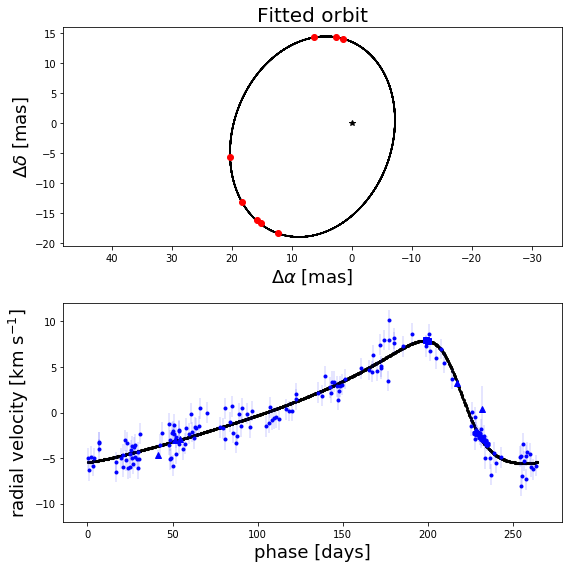

In [20]:
period = map_soln['P']
gamma = map_soln['gamma']
gamma_FEROS = map_soln['gamma_F']
gamma_CTIO = map_soln['gamma_C']
gamma_ELODIE = map_soln['gamma_E']

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

ax = axes[0]


ax.set_ylabel(r"$\Delta \delta$ [mas]", fontsize=18)
ax.errorbar(x, y, yerr=y_err, xerr=x_err, fmt="or")
ax.plot(map_soln["x_save"]*1000, map_soln["y_save"]*1000, color = "k")

ax.set_xlabel(r"$\Delta \alpha$ [mas]", fontsize=18)
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("Fitted orbit", fontsize=20)

ax = axes[1]
ax.errorbar(t % period, rva - gamma, yerr=rva_err, fmt=".b", label ="TO95", lw=0.2)
ax.errorbar(t_FEROS % period, rva_FEROS - gamma_FEROS, yerr=rva_err_FEROS, fmt="hb", label ="FEROS", lw=0.2)
ax.errorbar(t_CTIO % period, rva_CTIO - gamma_CTIO, yerr=rva_err_CTIO, fmt="^b", label ="CTIO", lw=0.2)
ax.errorbar(t_ELODIE % period, rva_ELODIE - gamma_ELODIE, yerr=rva_err_ELODIE, fmt="sb", label ="ELODIE", lw=0.2)

ax.scatter(t_fine % period, map_soln["va_save"], color = "k", marker='.', lw=0.1)

ax.set_ylabel("radial velocity [$\mathrm{km~s^{-1}}$]", fontsize=18)
ax.set_xlabel("phase [days]", fontsize=18)


axes[1].set_ylim(-12, 12)


plt.tight_layout()

In [21]:
#That looks fine, so now we can run the MCMC sampler:
np.random.seed(39091)
with model:
    trace = pmx.sample(
        tune=5000, draws=4000, start=map_soln, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterELODIE, logjitterCTIO, logjitterFEROS2, logjitterFEROS, logjitterTO95, a_ang, gamma_E, gamma_C, gamma_F2, gamma_F, gamma, K1, cos_incl, tp, ecc, Omega, omega, logP]


Sampling 4 chains for 5_000 tune and 4_000 draw iterations (20_000 + 16_000 draws total) took 427 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [20]:
# Then we can look at some summaries of the trace and the constraints on some of the key parameters:
with model:
    summary = pm.summary(
        trace,
        #var_names=["P", "tp", "gamma", "gamma_2", "a_ang", "omega", "Omega", "incl", "ecc", 'K1'],
        var_names=["P", "tp", "gamma", "a_ang", "omega", "Omega", "incl", "ecc", 'K1'],
        round_to=3
    )
    
summary
#print(summary[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']].to_latex())

mean     sd       hdi_3%      hdi_97%  mcse_mean  mcse_sd  \
P          264.507  0.020      264.470      264.546      0.000    0.000   
tp     2448742.976  0.782  2448741.501  2448744.465      0.007    0.005   
gamma       12.831  0.099       12.646       13.018      0.001    0.001   
a_ang        0.019  0.000        0.019        0.019      0.000    0.000   
omega        1.199  0.002        1.196        1.202      0.000    0.000   
Omega        2.970  0.003        2.965        2.975      0.000    0.000   
incl         2.366  0.002        2.363        2.370      0.000    0.000   
ecc          0.481  0.001        0.479        0.482      0.000    0.000   
K1           6.739  0.155        6.438        7.022      0.001    0.001   

        ess_mean     ess_sd   ess_bulk   ess_tail  r_hat  
P      11629.177  11629.177  11624.438   9095.907  1.000  
tp     11811.189  11641.567  11644.314   9082.105  1.000  
gamma  12367.241  12361.479  12383.709   9961.668  1.000  
a_ang  12297.210  12297.104  12295.977  10411.871  1.001  
omega  11713.898  11713.898  11744.377  10275.213  1.001  
Omega  11806.067  11806.067  11810.130  10054.488  1.000  
incl   12504.203  12504.190  12497.709   9706.815  1.000  
ecc    12263.071  12262.772  12258.760   9867.110  1.001  
K1     12420.254  12420.254  12413.827   9638.528  1.000

Period (days): 264.51$\pm$0.02
Tp (MJD): 48742.5$\pm$0.8
omega (deg): 68.7$\pm$0.1
Omega (deg): 170.2$\pm$0.1
i (deg): 135.6$\pm$0.1
a (mas): 19.04$\pm$0.01
e: 0.4808$\pm$0.0008
K1 (km/s): 6.7$\pm$0.2
gamma TO95 (km/s): 12.8$\pm$0.1
gamma FEROS (km/s): 14.4$\pm$0.3
gamma FEROS 2 (km/s): 12$\pm$2
gamma CTIO (km/s): 11.8$\pm$0.2
gamma ELODIE (km/s): 12.1$\pm$0.5


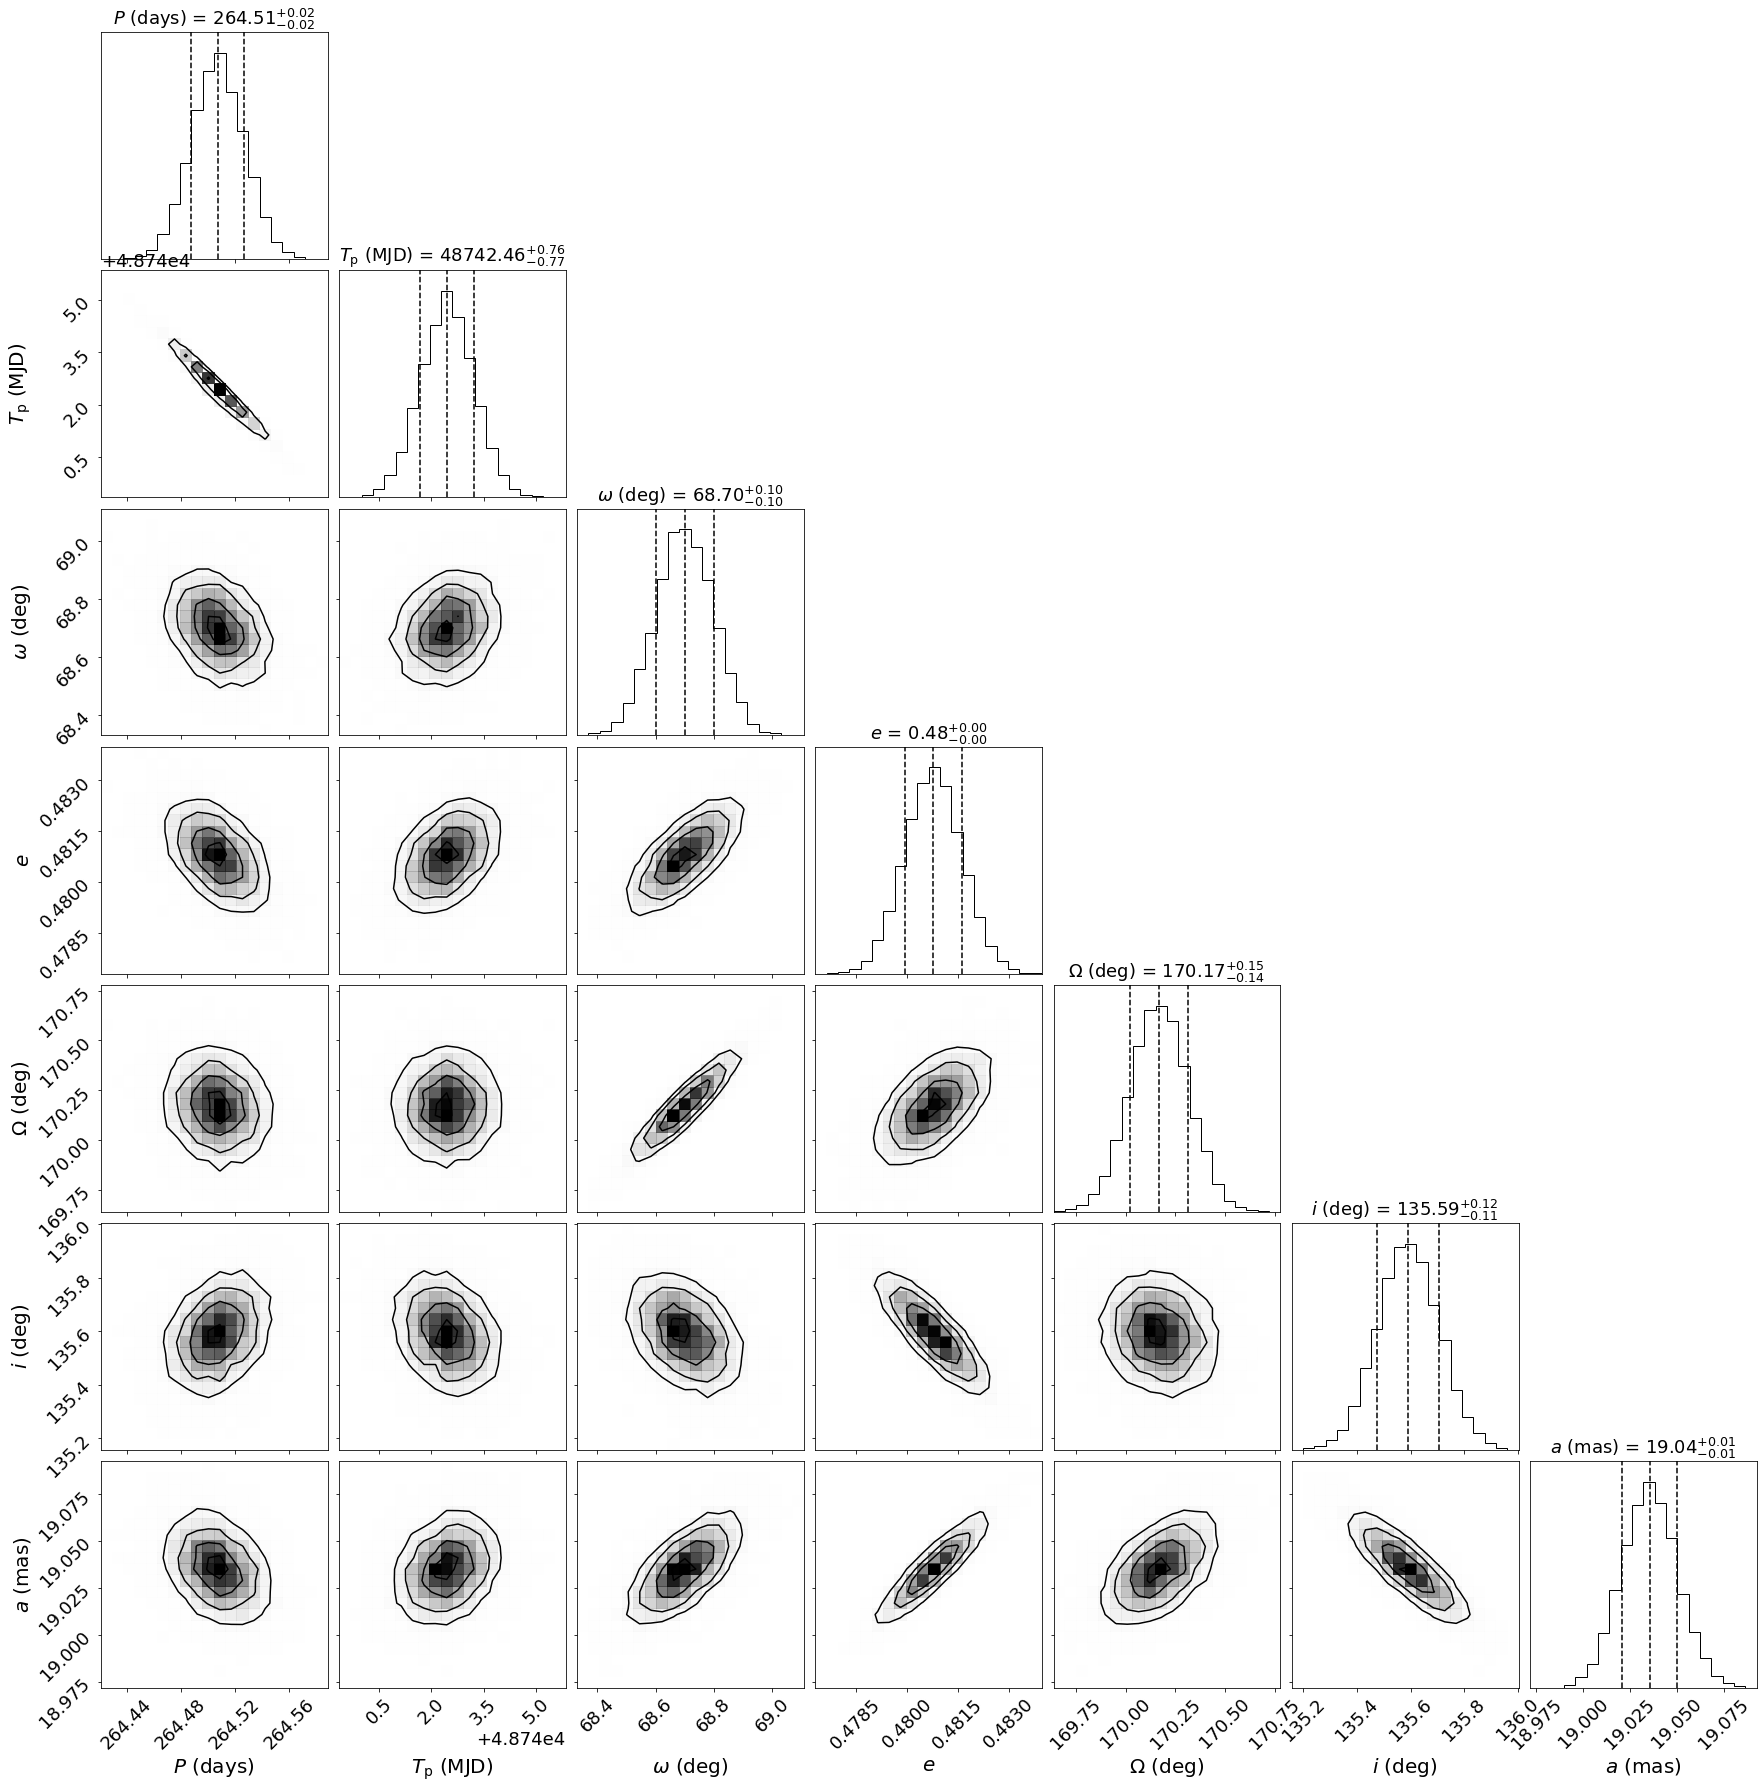

In [36]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$P$ (days)"] = trace["P"]
samples["$T_\mathrm{p}$ (MJD)"] = trace["tp"] - 2400000.5
samples["$\omega$ (deg)"] = (trace["omega"] * rad_2_deg) % 360
samples["$e$"] = trace["ecc"]
samples["$\Omega$ (deg)"] = (trace["Omega"] / deg) % 360
samples["$i$ (deg)"] = (trace["incl"] / deg) % 360
samples["$a$ (mas)"] = trace["a_ang"] * 1000
#samples["$K1$ [km/s]"] = (trace["K1"])
#samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])

period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
print("a (mas): "+round(str(aang), uncertainty=str(aang_s), separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s),separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F"])
print("gamma FEROS (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s),  separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F2"])
print("gamma FEROS 2 (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s),  separation='$\pm$'))

gammaC, gammaC_s = get_median_sigma(trace["gamma_C"])
print("gamma CTIO (km/s): "+round(str(gammaC), uncertainty=str(gammaC_s),  separation='$\pm$'))

gammaE, gammaE_s = get_median_sigma(trace["gamma_E"])
print("gamma ELODIE (km/s): "+round(str(gammaE), uncertainty=str(gammaE_s), separation='$\pm$'))

del samples["Omega"]
figure = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 18}, label_kwargs=dict(fontsize=20), plot_datapoints=False)

figure.subplots_adjust(right=1.5,top=1.5)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
#plt.savefig('AaAb_corner.pdf')  

figure.savefig('AaAb_corner.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

K1 (km/s): 6.7$\pm$0.2
gamma TO95 (km/s): 12.8$\pm$0.1
gamma FEROS (km/s): 14.4$\pm$0.3
gamma FEROS 2 (km/s): 12$\pm$2
gamma CTIO (km/s): 11.8$\pm$0.2
gamma ELODIE (km/s): 12.1$\pm$0.5


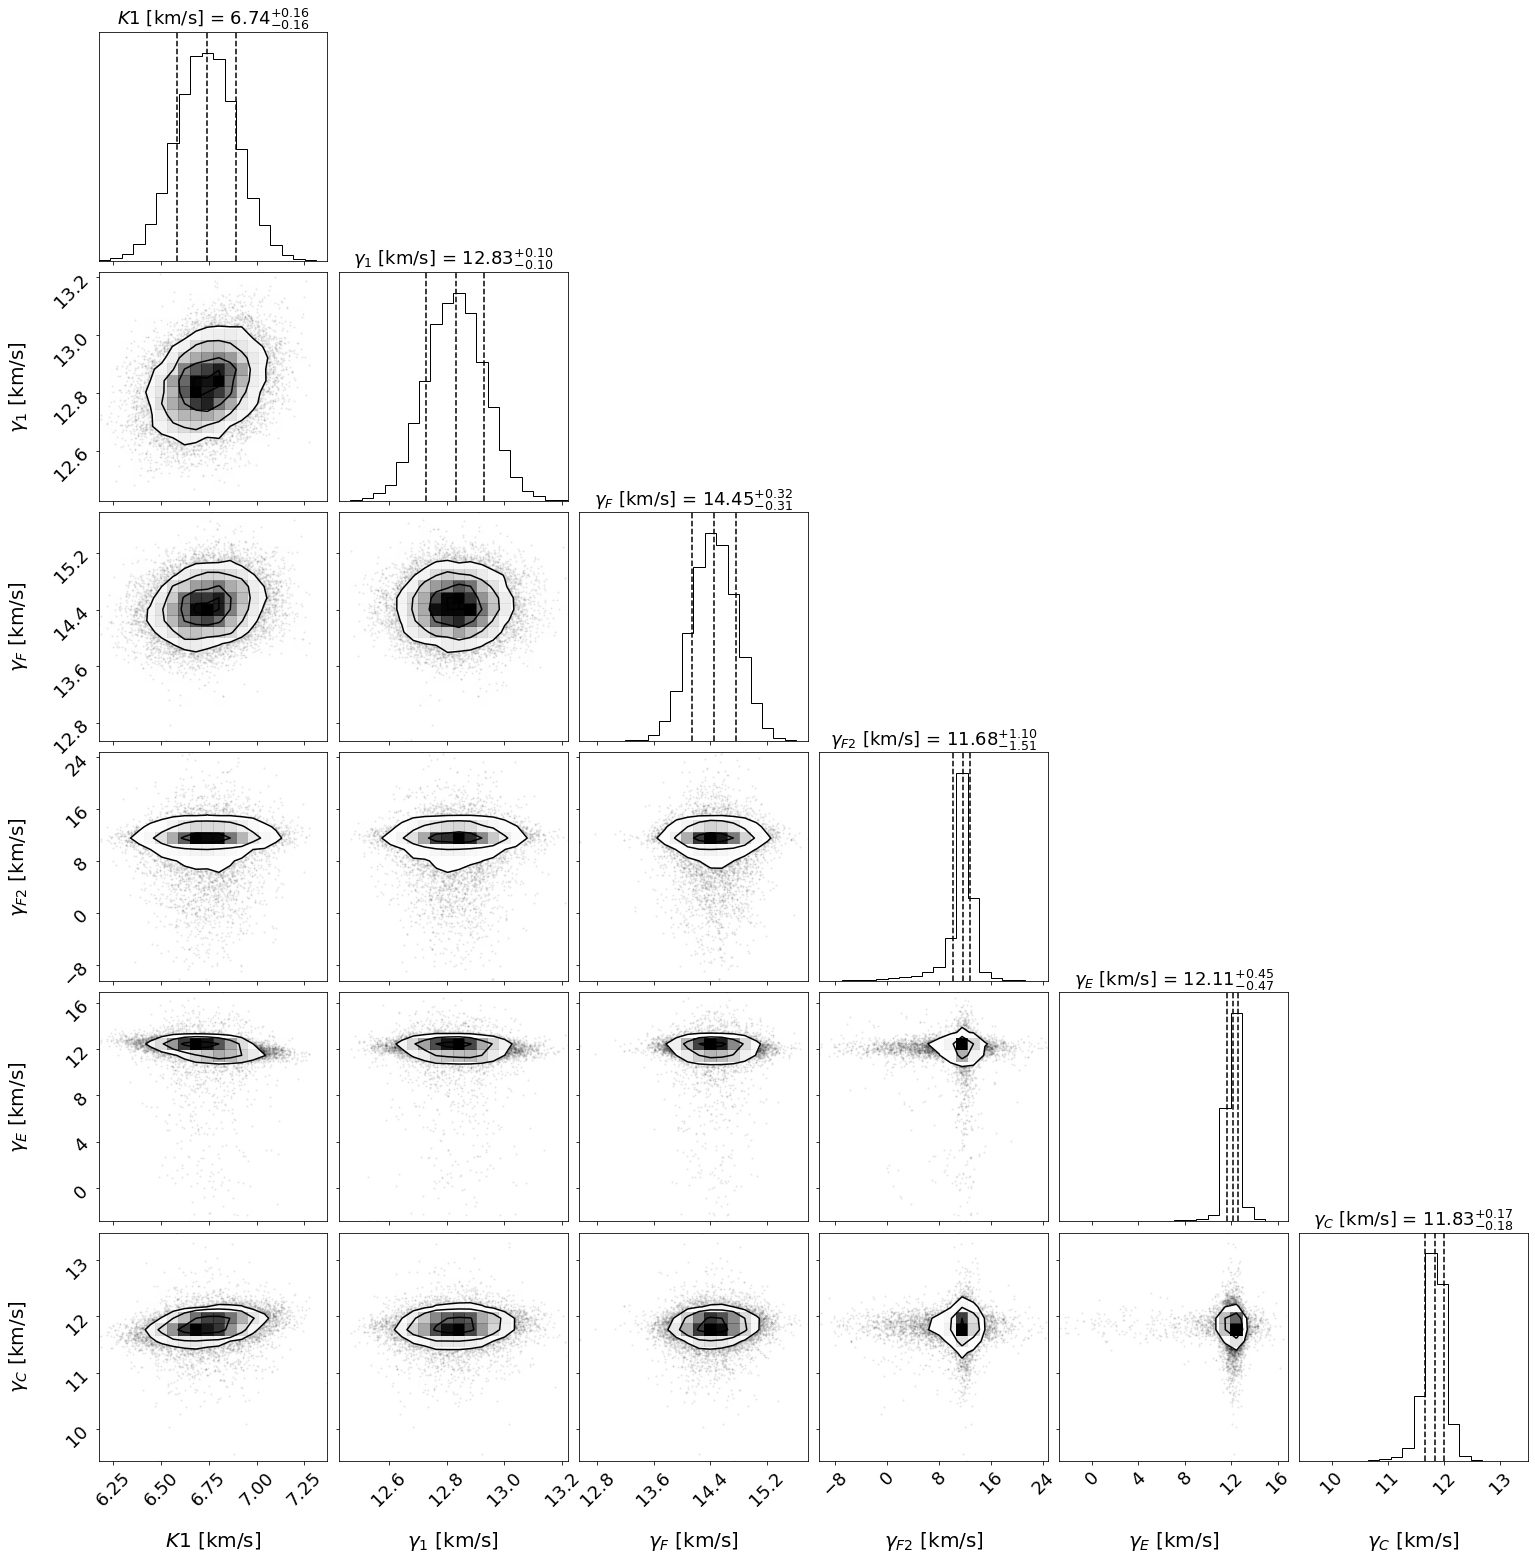

In [38]:
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$P$ (days)"] = trace["period"]
#samples["$T_\mathrm{p}$ (MJD)"] = trace["tp"] - 2400000.5
#samples["$\omega$ (deg)"] = (trace["omega"] * rad_2_deg) % 360
#samples["$e$"] = trace["ecc"]
#samples["$\Omega$ (deg)"] = (trace["Omega"] / deg) % 360
#samples["$i$ (deg)"] = (trace["incl"] / deg) % 360
#samples["$a$ (mas)"] = trace["a_ang"] * 1000
samples["$K1$ [km/s]"] = (trace["K1"])
samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
samples["$\gamma_F$ [km/s]"] = (trace["gamma_F"])
samples["$\gamma_{F2}$ [km/s]"] = (trace["gamma_F2"])
samples["$\gamma_E$ [km/s]"] = (trace["gamma_E"])
samples["$\gamma_C$ [km/s]"] = (trace["gamma_C"])

#period, period_s = get_median_sigma(trace["P"])
#print("Period (days): "+round(str(period), uncertainty=str(period_s), separation='$\pm$'))

#tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
#print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), separation='$\pm$'))

#omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
#print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), separation='$\pm$'))

#Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
#print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), separation='$\pm$'))

#inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
#print("i (deg): "+round(str(inc), uncertainty=str(inc_s), separation='$\pm$'))

#aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
#print("a (mas): "+round(str(aang), uncertainty=str(aang_s), separation='$\pm$'))

#ecc, ecc_s = get_median_sigma(trace["ecc"])
#print("e: "+round(str(ecc), uncertainty=str(ecc_s),separation='$\pm$'))

K1, K1_s = get_median_sigma(trace["K1"])
print("K1 (km/s): "+round(str(K1), uncertainty=str(K1_s), separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F"])
print("gamma FEROS (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s),  separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F2"])
print("gamma FEROS 2 (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s),  separation='$\pm$'))

gammaC, gammaC_s = get_median_sigma(trace["gamma_C"])
print("gamma CTIO (km/s): "+round(str(gammaC), uncertainty=str(gammaC_s),  separation='$\pm$'))

gammaE, gammaE_s = get_median_sigma(trace["gamma_E"])
print("gamma ELODIE (km/s): "+round(str(gammaE), uncertainty=str(gammaE_s), separation='$\pm$'))

del samples["Omega"]
figure = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True,
                  title_kwargs={"fontsize": 18}, label_kwargs=dict(fontsize=20))

figure.subplots_adjust(right=1.5,top=1.5)

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
    
#plt.savefig('AaAb_corner.pdf')  

#figure.savefig('AaAb_corner.pdf',dpi=300,pad_inches=0.3,bbox_inches='tight')

In [32]:
n_sim=len(trace['a_ang'])

c1 = 1.036149E-7
c2 = 9.191940E-5

# parallax from BaBb orbital solution 
#plx_BaBb = [18.8, 0.4]
plx_BaBb = [22.0,0.6]
# parallax from Validation of the new Hipparcos reduction (2007). 
plx_hip = [22.27, 2.31]
#plx_hip = [20.1, 0.3]
plx_Boden = [23.7, 2.6]


K1_t = trace["K1"]
ecc_t = trace["ecc"]
a_boden2005 = np.random.normal(23.3,2.5,n_sim)/1000

Bodenplx = np.random.normal(plx_Boden[0],plx_Boden[1],n_sim)/1000
BaBbplx = np.random.normal(plx_BaBb[0],plx_BaBb[1],n_sim)/1000

Hipplx = np.random.normal(plx_hip[0],plx_hip[1],n_sim)/1000

a_tBoden = a_boden2005/ (Bodenplx)
aBoden, aBoden_s = get_median_sigma(a_tBoden)

a_tB = trace["a_ang"]/ (BaBbplx)
aB, aB_s = get_median_sigma(a_tB)

a_tH = trace["a_ang"]/ (Hipplx)
aH, aH_s = get_median_sigma(a_tH)

P_t = trace["P"]
incl_tt = trace["incl"]

M22_B = ((c1 / (c2)**2) * K1_t * (1-ecc_t**2)**(1/2) * a_tB**2 ) / (P_t * np.sin(incl_tt))
M2B, M2B_s = get_median_sigma(M22_B)

M22_H = ((c1 / (c2)**2) * K1_t * (1-ecc_t**2)**(1/2) * a_tH**2 ) / (P_t * np.sin(incl_tt))
M2H, M2H_s = get_median_sigma(M22_H)

# Keppler third law
M_tB = (a_tB)**3 / (P_t/yr)**2
MTB, MTB_s = get_median_sigma(M_tB)

M_tH = (a_tH)**3 / (P_t/yr)**2
MTB, MTB_s = get_median_sigma(M_tB)

M11_B = M_tB-M22_B
M1B, M1B_s = get_median_sigma(M11_B)

M11_H = M_tH-M22_H
M1H, M1H_s = get_median_sigma(M11_H)

# BaBb plx
print("Using BaBb plx and Keppler laws")
print("a(AU): "+round(str(aB), uncertainty=str(aB_s), separation='$\pm$'))
print("Primary  mass: "+round(str(M1B), uncertainty=str(M1B_s), separation='$\pm$'))
print("Secondary  mass: "+round(str(M2B), uncertainty=str(M2B_s), separation='$\pm$'))
print("Mass ratio: "+str(M2B/M1B))
print('')
#Hipparcos
print("Using Hipparcos plx and Keppler laws")
print("a(AU): "+round(str(aH), uncertainty=str(aH_s), separation='$\pm$'))
print("Primary  mass: "+round(str(M1H), uncertainty=str(M1H_s), separation='$\pm$'))
print("Secondary  mass: "+round(str(M2H), uncertainty=str(M2H_s), separation='$\pm$'))
print("Mass ratio: "+str(M2H/M1H))
print('')
#Boden
print("a(AU) Boden: "+round(str(aBoden), uncertainty=str(aBoden_s), separation='$\pm$'))


Using BaBb plx and Keppler laws
a(AU): 0.87$\pm$0.02
Primary  mass: 0.94$\pm$0.09
Secondary  mass: 0.29$\pm$0.02
Mass ratio: 0.3109240153615761

Using Hipparcos plx and Keppler laws
a(AU): 0.9$\pm$0.1
Primary  mass: 0.9$\pm$0.4
Secondary  mass: 0.29$\pm$0.07
Mass ratio: 0.3161963730589081

a(AU) Boden: 1.0$\pm$0.2


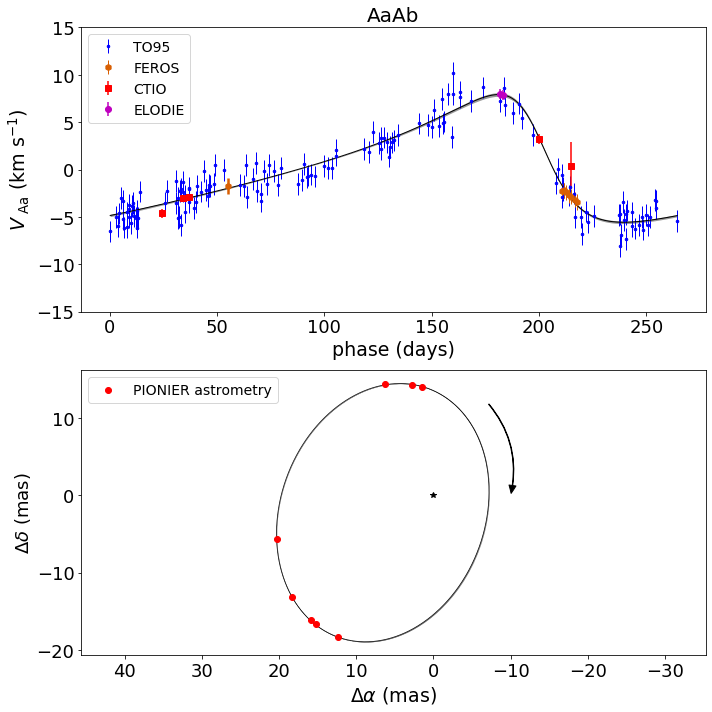

In [40]:
import matplotlib.patches as patches

# calculate the errors for each instrument
ELODIE_err = np.sqrt(rva_err_ELODIE**2 + np.exp(2 * np.median(trace["logjitterELODIE"])))
TO95_err = np.sqrt(rva_err**2 + np.exp(2 * np.median(trace["logjitterTO95"])))
CTIO_err = np.sqrt(rva_err_CTIO**2 + np.exp(2 * np.median(trace["logjitterCTIO"])))
FEROS_err = np.sqrt(rva_err_FEROS**2 + np.exp(2 * np.median(trace["logjitterFEROS"])))
FEROS_err2 = np.sqrt(rva_err_FEROS2**2 + np.exp(2 * np.median(trace["logjitterFEROS2"])))

#print(ELODIE_err[0])
#print(CTIO_err[0])
#print(FEROS_err[0])

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

period = np.percentile(trace["P"], [16, 50, 84], axis=0)
gamma = np.percentile(trace["gamma"], [16, 50, 84], axis = 0)
gamma_FEROS = np.percentile(trace["gamma_F"], [16, 50, 84], axis = 0)
gamma_FEROS2 = np.percentile(trace["gamma_F2"], [16, 50, 84], axis = 0)
gamma_CTIO = np.percentile(trace["gamma_C"], [16, 50, 84], axis = 0)
gamma_ELODIE = np.percentile(trace["gamma_E"], [16, 50, 84], axis = 0)

ax = axes[1]

style = "Simple, tail_width=0.5, head_width=7, head_length=8"
kw = dict(arrowstyle=style, color="k")

a3 = patches.FancyArrowPatch((-7.0, 12), (-10.0, 0),
                             connectionstyle="arc3,rad=-.25", **kw)
plt.gca().add_patch(a3)

# Plot the folded model
x_fold = t_fine % period[1]
inds = np.argsort(x_fold)

x_model = trace["x_save"][:, inds]
y_model = trace["y_save"][:, inds]

qx = np.percentile(x_model, [16, 50, 84], axis=0)
qy = np.percentile(y_model, [16, 50, 84], axis=0)



ax.set_ylabel(r"$\Delta \delta$ (mas)", fontsize=18)
ax.scatter(x, y, marker='o', color='r', label='PIONIER astrometry', zorder=3)
ax.plot(qx[1]*1000, qy[1]*1000, color = "k", lw=0.7, zorder=2)

# 1-sgima orbit range
ax.fill_between(qx[0]*1000, qy[0]*1000, qy[2]*1000, color="k", lw=0.2, alpha = 0.4, zorder=1)
ax.fill_between(qx[2]*1000, qy[0]*1000, qy[2]*1000, color="k", lw=0.2, alpha = 0.4, zorder=1)

ax.legend(loc='upper left', prop={'size': 14})
ax.set_xlabel(r"$\Delta \alpha$ (mas)", fontsize=19)
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")


ax = axes[0]


va_model = trace["va_save"][:, inds]
#vb_model = trace["vb_save"][:, inds]
va_model = np.percentile(va_model, [16, 50, 84], axis=0)
#vb_model = np.percentile(vb_model, [16, 50, 84], axis=0)

ax.plot(x_fold[inds], va_model[1], color="k", lw=1)
#plt.plot(x_fold[inds], -vb_model[1], color="k", label="model", lw=1.5)
ax.fill_between(x_fold[inds], va_model[0], va_model[2], color="k", lw=0.1, alpha = 0.4)
    
ax.errorbar(t % period[1], rva - gamma[1], yerr=TO95_err, fmt=".b", lw=1, label = "TO95", ms=5)
ax.errorbar(t_FEROS % period[1], rva_FEROS - gamma_FEROS[1], yerr=FEROS_err, fmt="h", color="#d95f02",
            lw=1, ms = 6, label="FEROS")
ax.errorbar(t_FEROS2 % period[1], rva_FEROS2 - gamma_FEROS2[1], yerr=FEROS_err2, fmt="h", color="#d95f02",
            lw=2.5, ms = 6)#, label="FEROS")
ax.errorbar(t_CTIO % period[1], rva_CTIO - gamma_CTIO[1], yerr=CTIO_err, fmt="sr",# color="#d95f02",
            lw=1.5, ms = 6, label="CTIO")
ax.errorbar(t_ELODIE % period[1], rva_ELODIE - gamma_ELODIE[1], yerr=ELODIE_err, fmt="om",
            lw=1.5, ms = 6, label="ELODIE")

ax.set_title("AaAb", fontsize=20)
ax.legend(loc='upper left', prop={'size': 14})
ax.set_ylim(-15,15)
ax.set_ylabel("$V_{~\mathrm{Aa}}$ ($\mathrm{km~s^{-1}}$)", fontsize=19)
ax.set_xlabel("phase (days)", fontsize=19)

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

#plt.rcParams.update({'font.size': 20})


plt.tight_layout()

plt.savefig('AaAb_Orbit.pdf')  

In [28]:
print("O-C ELODIE A")
print(np.percentile(trace["OC_ELOa"], [16, 50, 84], axis = 0)[1])
print(ELO_errA)

print("O-C FEROS")
print(np.percentile(trace["OC_FEROSa"], [16, 50, 84], axis = 0)[1])
print(FEROS_errA)

print("O-C FEROS 2")
print(np.percentile(trace["OC_FEROSa2"], [16, 50, 84], axis = 0)[1])
print(FEROS_err2)

print("O-C CTIO A")
print(np.percentile(trace["OC_CTIOa"], [16, 50, 84], axis = 0)[1])
print(CTIO_errA)

#print("")
#print("O-C astrometry")
#print(np.percentile(trace["Maj_err"], [16, 50, 84], axis = 0)[1])
#print(astro_sigma_maj)
#print("")
#print(np.percentile(trace["Min_err"], [16, 50, 84], axis = 0)[1])
#print(astro_sigma_min)

O-C ELODIE A
[ 0.08482002 -0.03348538]
[0.51517381 0.51517381]
O-C FEROS
[-0.56958897 -0.14239465 -0.09733915  0.01047852  0.00561968  0.16866265
  0.3847      0.36858667]
[0.80748705 0.80748705 0.80748705 0.80748705 0.80748705 0.80748705
 0.80748705 0.80748705]
O-C FEROS 2
[0.21763762]
[0.84881858]
O-C CTIO A
[-0.2043518   3.46116241 -0.95179413  0.17287185  0.04201714]
[0.50708553 2.50142674 0.50708553 0.21710765 0.21710765]


In [31]:
t_FEROS - 2400000.5

array([54308.4955, 54309.4913, 54309.5368, 54310.471 , 54311.4629,
       54312.49  , 54314.4636, 54315.4672])

In [31]:
#Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.
# Lets try each plx value and re-run the MCMC fit now using these values as a prior

yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 700, astro_jds.max() + 700, num=1000)

# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# 2021 in JD
#t_fine = np.linspace(2459215.50000, 2459579.50000, num=1000)

def get_model(parallax=None):
    with pm.Model() as model2:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=10, upper=30)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        
        # From our previous fit we set the priors
        logP = pm.Uniform(
            "logP", lower=np.log(250), upper=np.log(270), testval=np.log(P_astro[1])
        )
        
        P = pm.Deterministic("P", tt.exp(logP))

        omega = pm.Uniform("omega", lower=45*deg, upper=90*deg, testval=omega_RV[1])
        Omega = pm.Uniform("Omega", lower=0.0, upper=2*np.pi, testval=Omega_astro[1])
        
        ecc = pm.Uniform("ecc", lower=0.1, upper=0.9, testval=ecc_RV[1])
        
        tp = pm.Normal("tp", mu = tp_astro[1], sd = 10, testval=tp_astro[1])
        
        # Geometric uniform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval= np.cos(incl_astro[1])
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        
        # The RV model
        gamma = pm.Uniform("gamma", lower=5, upper=20, testval= gamma_RV[1])
        gamma_F = pm.Normal("gamma_F", mu=0.0, sd=10.0, testval=0.0)
        gamma_C = pm.Normal("gamma_C", mu=0.0, sd=10.0, testval=0.0)
        gamma_E = pm.Normal("gamma_E", mu=0.0, sd=10.0, testval=0.0)
        
        a_ang = pm.Uniform("a_ang", 0.005, 0.3, testval= a_astro[1]) #arcsec
        a = pm.Deterministic("a", a_ang / plx) # a(AU)
        
        
        if parallax is not None:
                # Since we're doing an RV + astrometric fit and plx, M2 now becomes a parameter of the model
                MAb = pm.Bound(pm.Normal, lower=0.001, upper=1)("MAb", mu=0.3, sd=0.5, testval=0.3) # solar masses
                
                orbit = xo.orbits.KeplerianOrbit(a=a*au_to_R_sun, period=P, ecc=ecc, t_periastron=tp,
                                                 omega=omega, Omega=Omega, incl=incl, m_planet=MAb)
                
                # now that we have a physical scale defined, the total mass of the system makes sense
                MA = pm.Deterministic("MA", orbit.m_total)
                MAa = pm.Deterministic("MAa", MA - MAb)
                
                # Set up the radial velocity model
                def model_rv1(t, offset):
                    return conv * orbit.get_star_velocity(t)[2] + offset  #km/s
                
                                  
        else:
            # Set up the orbit
            orbit = xo.orbits.KeplerianOrbit(
                a= a * au_to_R_sun,
                t_periastron= tp,
                period= P,
                incl= incl,
                ecc= ecc,
                omega= omega,
                Omega= Omega,
            )
            
            #Primary
            K1 = pm.Uniform("K1", lower=3, upper=10, testval= K1_RV[1])
            
            # Set up the radial velocity model
            def model_rv1(t,offset):
                return offset + orbit.get_radial_velocity(t,K=K1) #km/s
            
        logjit_TO95 = pm.Uniform("logjitterTO95", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_FEROS = pm.Uniform("logjitterFEROS", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_CTIO = pm.Uniform("logjitterCTIO", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        logjit_ELODIE = pm.Uniform("logjitterELODIE", lower=-5.0, upper=np.log(10), testval=np.log(1.0))
        jit_TO95 = pm.Deterministic("jitTO95", tt.exp(logjit_TO95))
        jit_FEROS = pm.Deterministic("jitFEROS", tt.exp(logjit_FEROS))
        jit_CTIO = pm.Deterministic("jitCTIO", tt.exp(logjit_CTIO))
        jit_ELODIE = pm.Deterministic("jitELODIE", tt.exp(logjit_ELODIE))
    
        # get the total errors
        def get_err(rv_err, logjitter):
            return tt.sqrt(rv_err**2 + tt.exp(2*logjitter))
   
        #Primary
        rvmodel_a = pm.Deterministic("rvmodel_a", model_rv1(t, gamma))
        rvmodel_a_FEROS = pm.Deterministic("rvmodel_a_FEROS", model_rv1(t_FEROS, gamma_F))
        rvmodel_a_CTIO = pm.Deterministic("rvmodel_a_CTIO", model_rv1(t_CTIO, gamma_C))
        rvmodel_a_ELODIE = pm.Deterministic("rvmodel_a_ELODIE", model_rv1(t_ELODIE, gamma_E))
        

        # Condition on the observations
        pm.Normal("obs_a", mu=rvmodel_a, sd=get_err(rva_err, logjit_TO95), observed=rva)
        pm.Normal("obs_a_FEROS", mu=rvmodel_a_FEROS, sd=get_err(rva_err_FEROS, logjit_FEROS),
                  observed=rva_FEROS)
        pm.Normal("obs_a_CTIO", mu=rvmodel_a_CTIO, sd=get_err(rva_err_CTIO, logjit_CTIO),
                  observed=rva_CTIO)
        pm.Normal("obs_a_ELODIE", mu=rvmodel_a_ELODIE, sd=get_err(rva_err_ELODIE, logjit_ELODIE),
                  observed=rva_ELODIE)


        # Compute the model in x,y
        y_model, x_model, z_model = orbit.get_relative_position(astro_jds, plx)
        pm.Deterministic("x_model", x_model)
        pm.Deterministic("y_model", y_model)
        
        # define the likelihood function, e.g., a Gaussian on both x and y
        #pm.Normal("x_obs", mu=x_model, sd=x_err/1000, observed=x/1000)
        #pm.Normal("y_obs", mu=y_model, sd=y_err/1000, observed=y/1000)
        
        # Elipse error model
        # semi-major axis error
        Maj_err = (x_model - x/1000)*tt.cos(astrometry_PA*deg)+(y_model- y/1000)*tt.sin(astrometry_PA*deg)
        # semi-minor axis error
        Min_err = -(y_model-y/1000)*tt.cos(astrometry_PA*deg)+(x_model-x/1000)*tt.sin(astrometry_PA*deg)
        
        # define the likelihood function
        pm.Normal("sigmaMaj_obs", mu=Maj_err, sd=astro_sigma_maj/1000, observed=0.0)
        pm.Normal("sigmaMin_obs", mu=Min_err, sd=astro_sigma_min/1000, observed=0.0)
        
        
        # Set up predicted orbits for later plotting
        y_dense, x_dense, z_dense = orbit.get_relative_position(t_fine, plx)
        x_save = pm.Deterministic("x_save", x_dense)
        y_save = pm.Deterministic("y_save", y_dense)
        

        va_dense = conv * orbit.get_star_velocity(t_fine)[2]
        #vb_dense = orbit.get_radial_velocity(t_fine,K2)
        
        va_save = pm.Deterministic("va_save",va_dense)
        #vb_save = pm.Deterministic("vb_save",vb_dense)
        
        # Optimize to find the initial parameters
        # Optimize the logp
        map_soln2 = model2.test_point
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend])
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend, phase, ecc, omega])
        #map_soln = pmx.optimize(map_soln, [rv0, rvtrend, phase, logK1])
        #map_soln = pmx.optimize(map_soln, [logP, omega, Omega, a_ang])
        map_soln2 = pmx.optimize(map_soln2)


    return model2, map_soln2


model2, map_soln2 = get_model(parallax=plx_BaBb)

optimizing logp for variables: [logjitterELODIE, logjitterCTIO, logjitterFEROS, logjitterTO95, MAb, a_ang, gamma_E, gamma_C, gamma_F, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -4077.1560413883453 -> -261.5225838132387


In [33]:
# Now we can run the MCMC sampler:
np.random.seed(39091)
with model2:
    trace = pmx.sample(
        tune=4000, draws=3000, start=map_soln2, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterELODIE, logjitterCTIO, logjitterFEROS, logjitterTO95, MAb, a_ang, gamma_E, gamma_C, gamma_F, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


Sampling 4 chains for 4_000 tune and 3_000 draw iterations (16_000 + 12_000 draws total) took 204 seconds.
The number of effective samples is smaller than 25% for some parameters.


Period (days): 264.506$\pm$0.020
Tp (MJD): 48742.5$\pm$0.8
omega (deg): 68.70$\pm$0.10
Omega (deg): 170.16$\pm$0.15
i (deg): 135.59$\pm$0.12
a (mas): 19.035$\pm$0.015
e: 0.4808$\pm$0.0008
M2: 0.292$\pm$0.018
gamma TO95 (km/s): 12.84$\pm$0.10
gamma FEROS (km/s): 14.7$\pm$0.4
gamma CTIO (km/s): 11.82$\pm$0.29


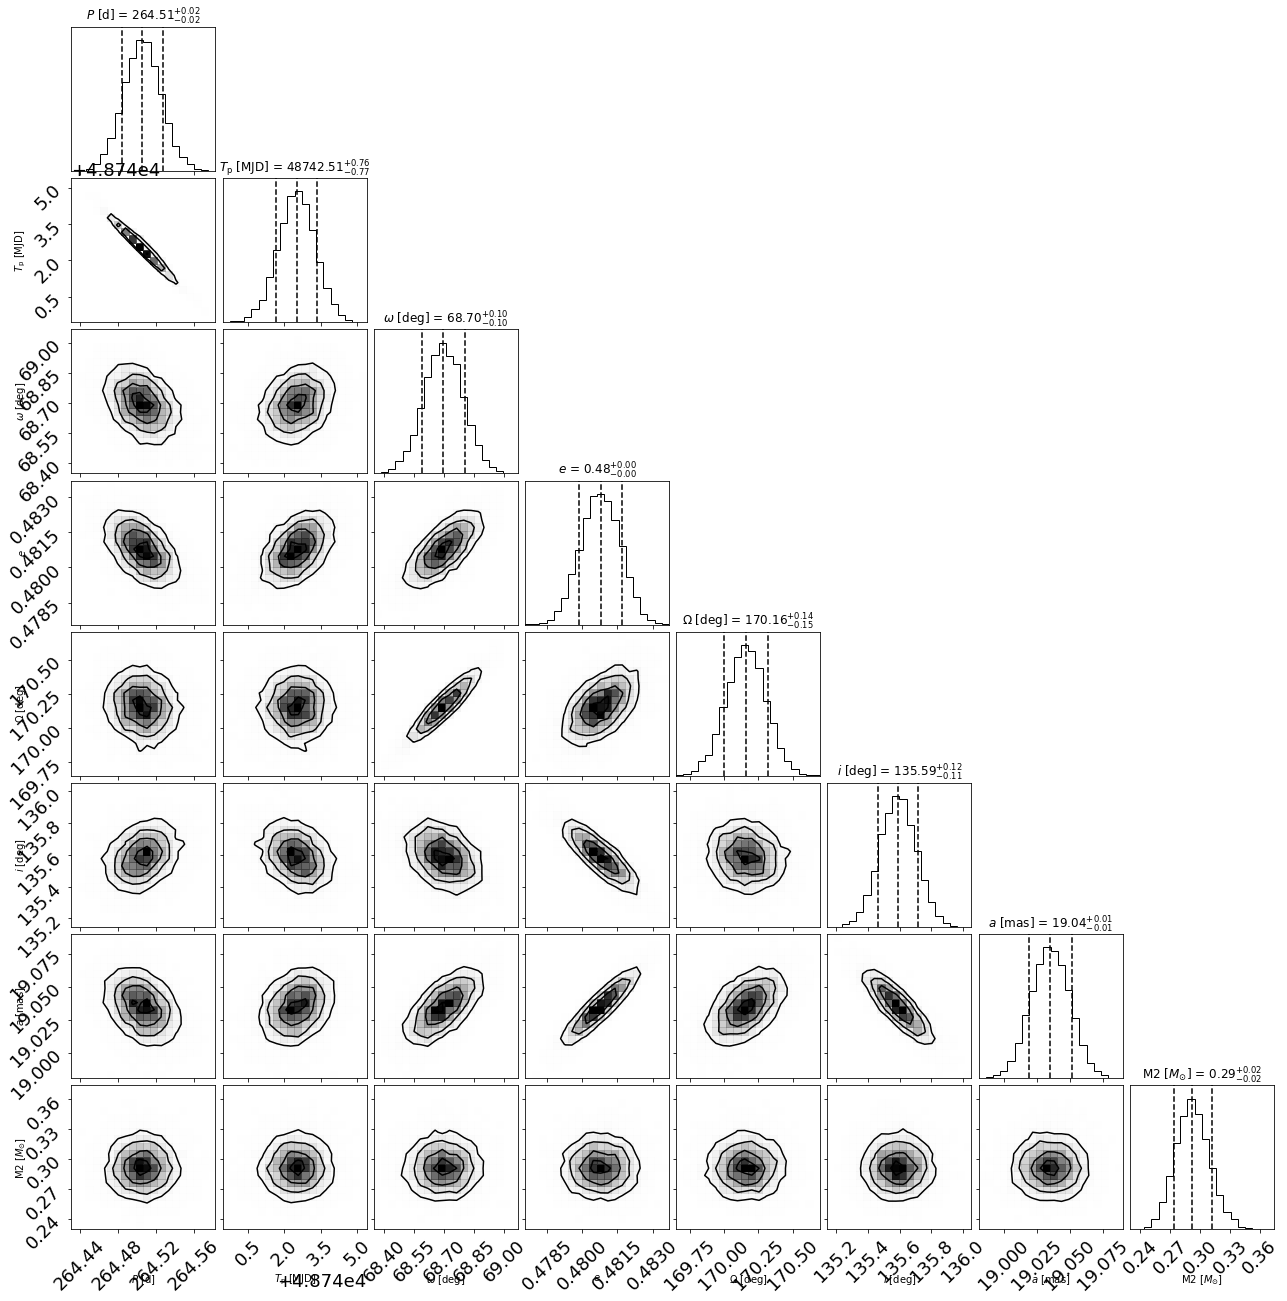

In [34]:
# Check the new fitting results
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$P$ [d]"] = trace["P"]
samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
samples["$\omega$ [deg]"] = (trace["omega"] * rad_2_deg) % 360
samples["$e$"] = trace["ecc"]
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 180
samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["M2 [$M_{\odot}$]"] = (trace["MAb"]) 
#samples["$K1$ [km/s]"] = (trace["K1"])
#samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])

period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), format='PDG', separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), format='PDG', separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), format='PDG', separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), format='PDG', separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), format='PDG', separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
print("a (mas): "+round(str(aang), uncertainty=str(aang_s), format='PDG', separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), format='PDG', separation='$\pm$'))

MA2, MA2_s = get_median_sigma(trace["MAb"])
print("M2: "+round(str(MA2), uncertainty=str(MA2_s), format='PDG', separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), format='PDG', separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F"])
print("gamma FEROS (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s), format='PDG', separation='$\pm$'))

gammaC, gammaC_s = get_median_sigma(trace["gamma_C"])
print("gamma CTIO (km/s): "+round(str(gammaC), uncertainty=str(gammaC_s), format='PDG', separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.136, 0.5, 0.864], show_titles=True,
                  title_kwargs={"fontsize": 12}, plot_datapoints=False)


#plt.savefig('AaAb_corner.pdf')  

M1: 0.93$\pm$0.09
M2: 0.29$\pm$0.02
plx (mas): 22.1$\pm$0.6
a (AU): 0.86$\pm$0.02


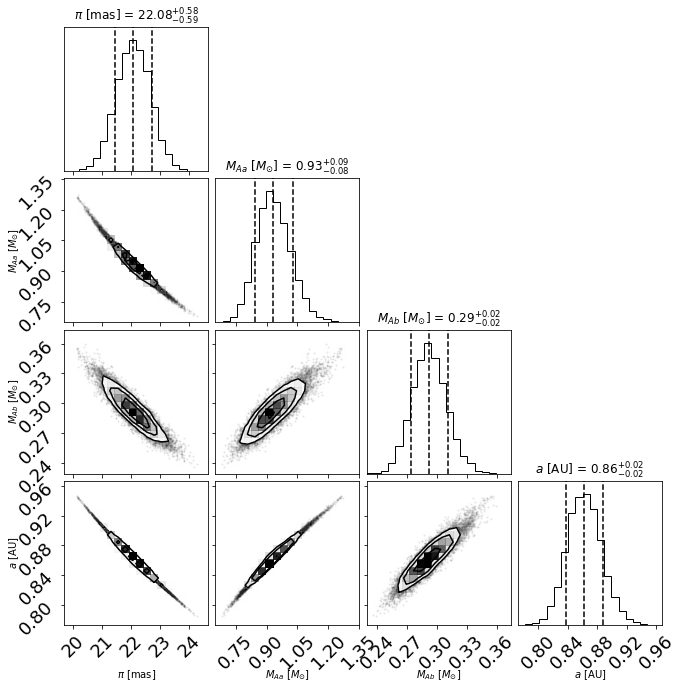

In [37]:
# Lets check the estimated physical parameters

samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$P$ [d]"] = trace["P"]
#samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
#samples["$\omega$ [deg]"] = (trace["omega"] * rad_2_deg) % 360
#samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
#samples["$M_{t}$"] = trace["MA"]
samples["$\pi$ [mas]"] = trace["m_plx"]
samples["$M_{Aa}$ [$M_{\odot}$]"] = (trace["MAa"])
samples["$M_{Ab}$ [$M_{\odot}$]"] = (trace["MAb"]) 
#samples["$K2$ [km/s]"] = (trace["K_2"])
#samples["$K1$ [km/s]"] = (trace["K1"])
#samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])
samples["$a$ [AU]"] = trace["a"]
#samples["$i$ [deg]"] = (trace["incl"] / deg) % 360




M1b, M1b_s = get_median_sigma(trace["MAa"])
print("M1: "+round(str(M1b), uncertainty=str(M1b_s), separation='$\pm$'))

M2b, M2b_s = get_median_sigma(trace["MAb"])
print("M2: "+round(str(M2b), uncertainty=str(M2b_s), separation='$\pm$'))

plxb, plxb_s = get_median_sigma(trace["m_plx"])
print("plx (mas): "+round(str(plxb), uncertainty=str(plxb_s), separation='$\pm$'))

ah, ah_s = get_median_sigma(trace["a"])
print("a (AU): "+round(str(ah), uncertainty=str(ah_s), separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.136, 0.5, 0.864], show_titles=True,
                  title_kwargs={"fontsize": 12})

#Save masses and plx for later comparison
samples_sol1 = samples[["$M_{Aa}$ [$M_{\odot}$]","$M_{Ab}$ [$M_{\odot}$]","$\pi$ [mas]"]]

In [31]:
with model2:
    txt, bib = xo.citations.get_citations_for_model()
    
print(bib)


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Timothy D. Brandt and
            Tom Barclay and Luke Bouma},
   title = {exoplanet-dev/exoplanet v0.4.0},
   month = oct,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@article{exoplanet:astropy13,
  

In [32]:
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [38]:
# Try now with the Hipparcos plx

model2, map_soln2 = get_model(parallax=plx_hip)

optimizing logp for variables: [logjitterELODIE, logjitterCTIO, logjitterFEROS, logjitterTO95, MAb, a_ang, gamma_E, gamma_C, gamma_F, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


message: Desired error not necessarily achieved due to precision loss.
logp: -4079.3841163995203 -> -262.8648199907729


In [39]:
# Now we can run the MCMC sampler:
np.random.seed(39091)
with model2:
    trace = pmx.sample(
        tune=4000, draws=3000, start=map_soln2, chains=4, cores=4, target_accept=0.9, init="adapt_full",
    )

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logjitterELODIE, logjitterCTIO, logjitterFEROS, logjitterTO95, MAb, a_ang, gamma_E, gamma_C, gamma_F, gamma, cos_incl, tp, ecc, Omega, omega, logP, m_plx]


Sampling 4 chains for 4_000 tune and 3_000 draw iterations (16_000 + 12_000 draws total) took 240 seconds.
The number of effective samples is smaller than 25% for some parameters.


Period (days): 264.506$\pm$0.020
Tp (MJD): 48742.5$\pm$0.8
omega (deg): 68.70$\pm$0.10
Omega (deg): 170.16$\pm$0.15
i (deg): 135.59$\pm$0.12
a (mas): 19.035$\pm$0.015
e: 0.4808$\pm$0.0008
M2: 0.30$\pm$0.07
gamma TO95 (km/s): 12.83$\pm$0.10
gamma FEROS (km/s): 14.7$\pm$0.4
gamma CTIO (km/s): 11.82$\pm$0.28


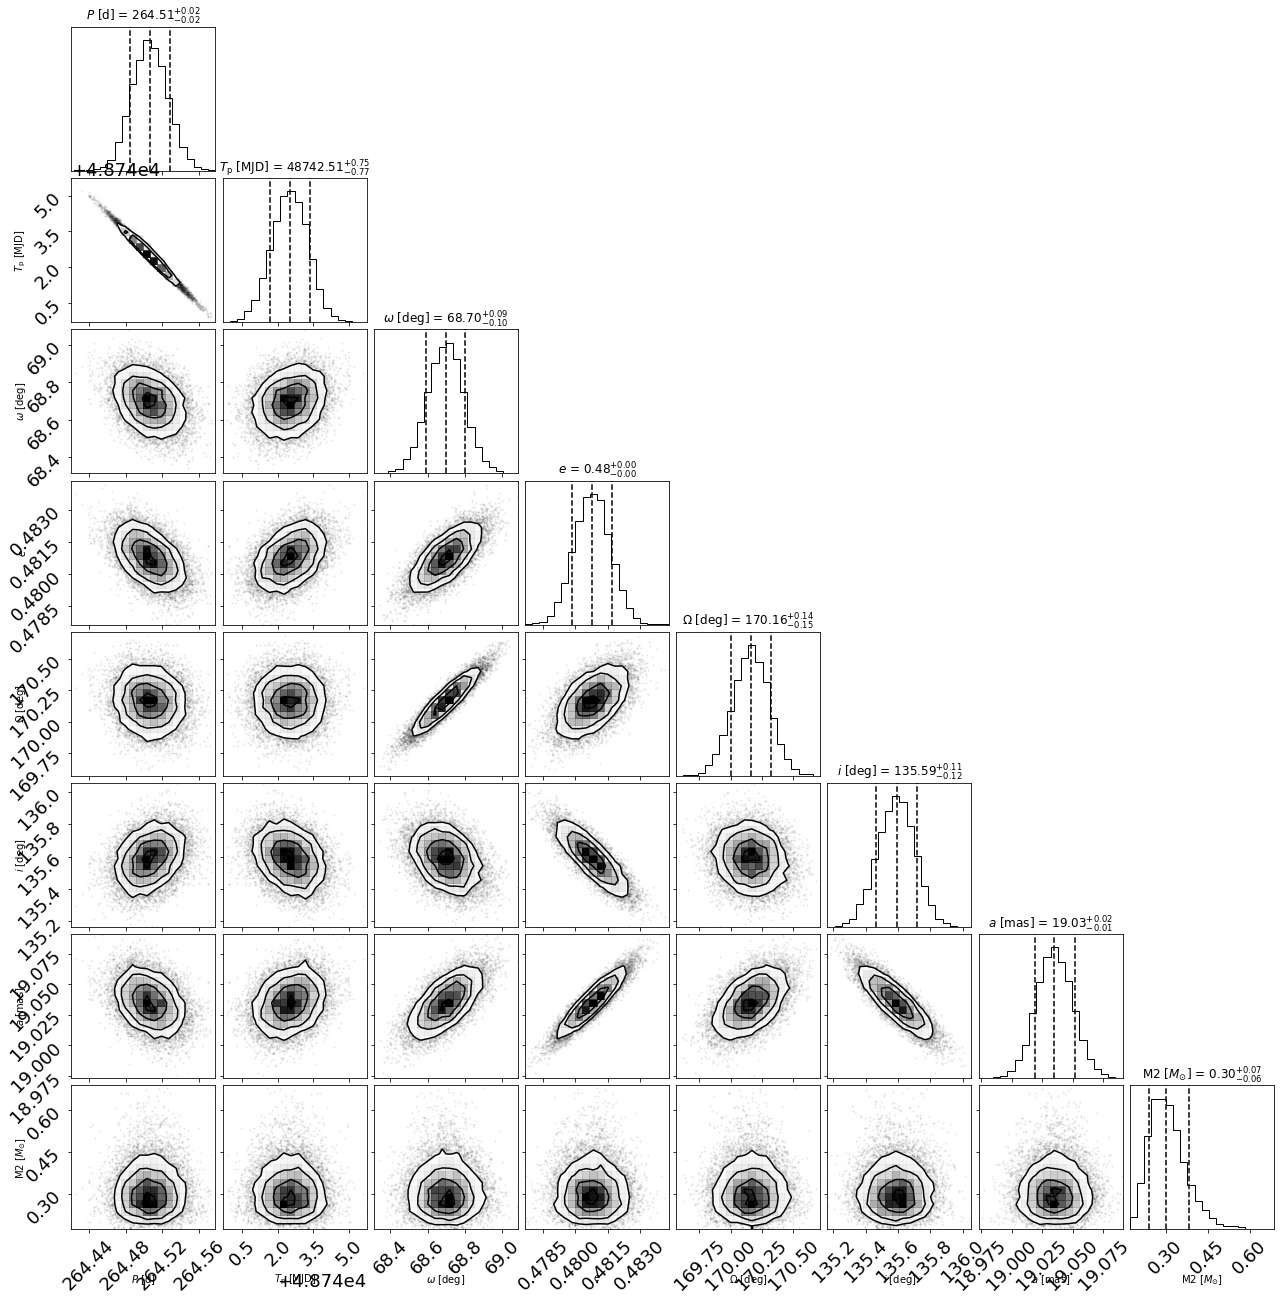

In [40]:
# Check the new fitting results
samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
samples["$P$ [d]"] = trace["P"]
samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
samples["$\omega$ [deg]"] = (trace["omega"] * rad_2_deg) % 360
samples["$e$"] = trace["ecc"]
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 180
samples["$a$ [mas]"] = trace["a_ang"] * 1000
samples["M2 [$M_{\odot}$]"] = (trace["MAb"]) 
#samples["$K1$ [km/s]"] = (trace["K1"])
#samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])

period, period_s = get_median_sigma(trace["P"])
print("Period (days): "+round(str(period), uncertainty=str(period_s), format='PDG', separation='$\pm$'))

tp, tp_s = get_median_sigma(trace["tp"]- 2400000.5)
print("Tp (MJD): "+round(str(tp), uncertainty=str(tp_s), format='PDG', separation='$\pm$'))

omega, omega_s = get_median_sigma((trace["omega"] * rad_2_deg) % 360)
print("omega (deg): "+round(str(omega), uncertainty=str(omega_s), format='PDG', separation='$\pm$'))

Omega, Omega_s = get_median_sigma((trace["Omega"] * rad_2_deg) % 360)
print("Omega (deg): "+round(str(Omega), uncertainty=str(Omega_s), format='PDG', separation='$\pm$'))

inc, inc_s = get_median_sigma((trace["incl"] * rad_2_deg) % 180)
print("i (deg): "+round(str(inc), uncertainty=str(inc_s), format='PDG', separation='$\pm$'))

aang, aang_s = get_median_sigma(trace["a_ang"]*1000)
print("a (mas): "+round(str(aang), uncertainty=str(aang_s), format='PDG', separation='$\pm$'))

ecc, ecc_s = get_median_sigma(trace["ecc"])
print("e: "+round(str(ecc), uncertainty=str(ecc_s), format='PDG', separation='$\pm$'))

MA2, MA2_s = get_median_sigma(trace["MAb"])
print("M2: "+round(str(MA2), uncertainty=str(MA2_s), format='PDG', separation='$\pm$'))

gamma, gamma_s = get_median_sigma(trace["gamma"])
print("gamma TO95 (km/s): "+round(str(gamma), uncertainty=str(gamma_s), format='PDG', separation='$\pm$'))

gammaL, gammaL_s = get_median_sigma(trace["gamma_F"])
print("gamma FEROS (km/s): "+round(str(gammaL), uncertainty=str(gammaL_s), format='PDG', separation='$\pm$'))

gammaC, gammaC_s = get_median_sigma(trace["gamma_C"])
print("gamma CTIO (km/s): "+round(str(gammaC), uncertainty=str(gammaC_s), format='PDG', separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.136, 0.5, 0.864], show_titles=True,
                  title_kwargs={"fontsize": 12})


M1: 1.0$\pm$0.4
M2: 0.30$\pm$0.07
plx (mas): 22$\pm$2
a (AU): 0.9$\pm$0.1


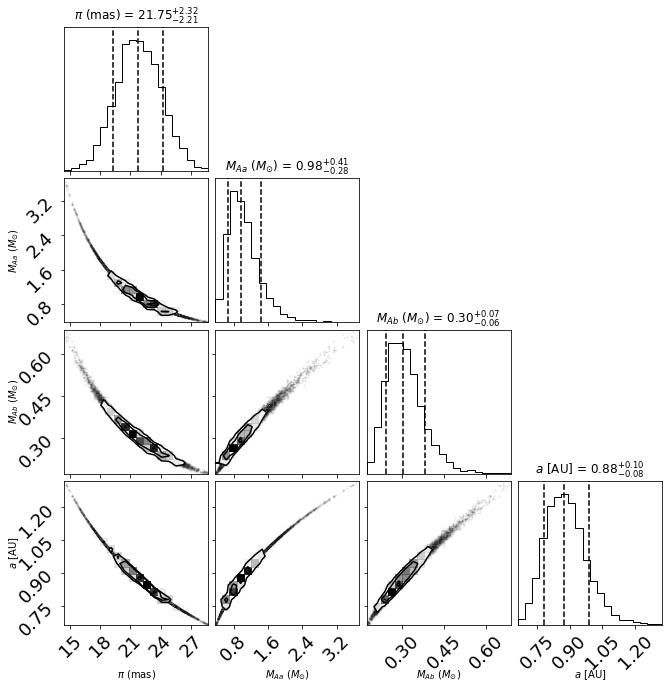

In [41]:
# Lets check the estimated physical parameters

samples = pm.trace_to_dataframe(trace, varnames=["Omega"])
#samples["$P$ [d]"] = trace["P"]
#samples["$T_\mathrm{p}$ [MJD]"] = trace["tp"] - 2400000.5
#samples["$\omega$ [deg]"] = (trace["omega"] * rad_2_deg) % 360
#samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
#samples["$M_{t}$"] = trace["MA"]
samples["$\pi$ (mas)"] = trace["m_plx"]
samples["$M_{Aa}$ ($M_{\odot}$)"] = (trace["MAa"])
samples["$M_{Ab}$ ($M_{\odot}$)"] = (trace["MAb"]) 
#samples["$K2$ [km/s]"] = (trace["K_2"])
#samples["$K1$ [km/s]"] = (trace["K1"])
#samples["$\gamma_1$ [km/s]"] = (trace["gamma"])
#samples["$\gamma_2$ [km/s]"] = (trace["gamma_2"])
samples["$a$ [AU]"] = trace["a"]
#samples["$i$ [deg]"] = (trace["incl"] / deg) % 360

#Save masses and plx for later comparison
samples_sol2 = samples[["$M_{Aa}$ ($M_{\odot}$)","$M_{Ab}$ ($M_{\odot}$)","$\pi$ (mas)"]]


M1h, M1h_s = get_median_sigma(trace["MAa"])
print("M1: "+round(str(M1h), uncertainty=str(M1h_s), separation='$\pm$'))

M2h, M2h_s = get_median_sigma(trace["MAb"])
print("M2: "+round(str(M2h), uncertainty=str(M2h_s), separation='$\pm$'))

plxh, plxh_s = get_median_sigma(trace["m_plx"])
print("plx (mas): "+round(str(plxh), uncertainty=str(plxh_s), separation='$\pm$'))

ah, ah_s = get_median_sigma(trace["a"])
print("a (AU): "+round(str(ah), uncertainty=str(ah_s), separation='$\pm$'))

del samples["Omega"]
_ = corner.corner(samples,quantiles=[0.136, 0.5, 0.864], show_titles=True,
                  title_kwargs={"fontsize": 12})


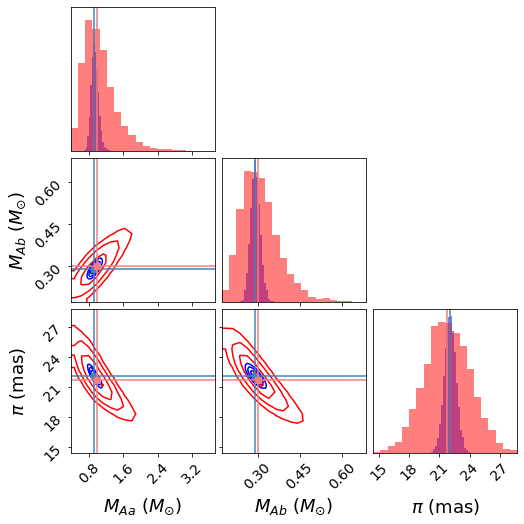

In [71]:
# Blue: Solution using BaBb plx
figure = corner.corner(samples_sol1, show_titles=False,
                   plot_density=False, color='blue', smooth= True, range = [1,1,0.999],
                       plot_datapoints=False,fill_contours=False, truths = [M1b,M2b,plx_BaBb[0]],
                      hist_kwargs={'histtype': 'stepfilled', 'alpha':0.5})

# Red: Solution using Hipp. plx
corner.corner(samples_sol2, fig=figure, color='red',plot_density=False, 
              title_kwargs={"fontsize": 10}, show_titles=False, truths = [M1h,M2h,plxh],
              plot_datapoints=False,fill_contours=False, smooth= True, truth_color= 'lightcoral',
             hist_kwargs={'histtype': 'stepfilled', 'alpha':0.5},label_kwargs=dict(fontsize=18))

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=14)

plt.savefig('AaAb_mass.pdf')  
plt.show()